# RLCT estimation

In [1]:
import torch

from devinterp.slt.sampler import Sampler, SamplerConfig
from devinterp.evals import SamplerEvaluator
from devinterp.ops.storage import CheckpointerConfig
from devinterp.optim.optimizers import OptimizerConfig

from icl.config import get_config
from icl.evals import ICLEvaluator
from icl.utils import set_seed

/home/paperspace/Projects/icl/.venv/lib/python3.9/site-packages/pydantic/_internal/_fields.py:127: UserWarning: Field "model_seed" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
hashes = {
    1: "f1ca8b",
    128: "245ac2",
    1024: "4049f0",
    131072: "907f8b",
    16: "793f89",
    2: "3e1d6b",
    2048: "62cacf",
    256: "ab678b",
    262144: "d9d52c",
    32: "bd2025",
    32768: "ee4af9", 
    4: "cb4bf2", 
    512: "b6cf20", 
    524288: "b37c11", 
    64: "981760", 
    65536: "679f8b",
    8: "ad074e"
}

In [3]:
configs = []

for num_tasks in [2**i for i in range(21)]:
    if num_tasks in hashes:
        configs.append(get_config(task_config={"num_tasks": num_tasks}, 
                                  checkpointer_config={"project_dir": f"icl/ntasks-{num_tasks}-task-{hashes[num_tasks]}-opt-f7c569-sched-c4766a"}
            ))


import yaml
print(yaml.dump(configs[1].model_dump()))

batch_size: 256
checkpointer_config:
  bucket_name: devinterp
  device: cpu
  local_root: null
  project_dir: icl/ntasks-2-task-3e1d6b-opt-f7c569-sched-c4766a
criterion: cross_entropy
device: cuda
eval_batch_size: 2048
logger_config:
  entity: null
  metrics: null
  out_file: null
  project: null
  run_id: null
  stdout: false
  use_df: false
num_steps: 500000
num_training_samples: 128000000
optimizer_config:
  betas: !!python/tuple
  - 0.9
  - 0.999
  elasticity: null
  lr: 0.001
  momentum: null
  noise_level: null
  num_samples: null
  optimizer_type: Adam
  temperature: null
  weight_decay: 0.0
scheduler_config:
  T_max: null
  anneal_strategy: linear
  cycle_momentum: false
  div_factor: 249999.0
  eta_min: null
  final_div_factor: 249999.0
  gamma: null
  last_epoch: -1
  lr_lambda: null
  max_lr: 0.001
  milestones: null
  pct_start: 0.5
  scheduler_type: OneCycleLR
  step_size: null
  total_steps: 500000
task_config:
  embed_size: 128
  max_examples: 16
  mlp_size: 128
  model_

/home/paperspace/Projects/devinterp/devinterp/utils.py:47: UserWarning: Number of steps in int_logspace is not 100, got 91.
  warnings.warn(
/home/paperspace/Projects/devinterp/devinterp/utils.py:47: UserWarning: Number of steps in int_logspace is not 50, got 47.
  warnings.warn(


In [4]:
from tqdm.notebook import tqdm

# Get the checkpoints
checkpointers = []

for config in tqdm(configs, desc="Reading checkpoints"):
    # print(yaml.dump(config.checkpointer_config.model_dump()))
    checkpointer = config.checkpointer_config.factory().sync()
    checkpointer.file_ids = sorted([int(x) for x in checkpointer.file_ids])
    checkpointers.append(checkpointer)

import numpy as np

print("\n".join([str(checkpointer.providers[0].root_dir)[23:-36] + ": " + str(tuple(checkpointer.file_ids)) for checkpointer in checkpointers]))

Reading checkpoints:   0%|          | 0/17 [00:00<?, ?it/s]

/home/paperspace/Projects/devinterp/devinterp/ops/storage.py:105: UserWarning: Using default key_to_id. This yields a string, which may not be what you want.
  warnings.warn(


1: (0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408, 26279, 30612, 34349)
2: (0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408, 26279, 30612, 34349, 40816, 44897, 51020, 58684, 61224, 71428, 76706, 81632)
4: (0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408, 26279, 30612, 34349, 40816, 44897, 51020, 58684, 61224, 71428, 76706, 81632)
8: (0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124, 162, 211, 276, 362, 473, 618, 808, 1056, 1381, 1805, 2359, 3084, 4031, 5269, 6887, 9003, 10204, 11767, 15381, 20104, 20408)
16: (0, 1, 2, 3, 4, 6, 8, 11, 14, 19, 24, 32, 42, 55, 72, 94, 124

In [7]:
config = configs[0]

# initialise model
model = config.task_config.model_factory().to(config.device)

# initialise 'pretraining' data source (for training on fixed task set)
pretrain_dist = config.task_config.pretrain_dist_factory().to(config.device)

# initialise 'true' data source (for evaluation, including unseen tasks)
true_dist = config.task_config.true_dist_factory().to(config.device)

# initialise evaluations
evaluator = ICLEvaluator(
    pretrain_dist=pretrain_dist,
    true_dist=true_dist,
    max_examples=config.task_config.max_examples,
    eval_batch_size=config.eval_batch_size,
)

# Load model
# model.load_state_dict(checkpointers[0][-1]["model"])
# evaluator(model)

In [8]:
import itertools
from dataclasses import dataclass
from logging import Logger
from typing import Callable, Dict, Literal, Optional, Tuple, Union

import torch
import yaml
from pydantic import BaseModel, Field, validator
from torch import nn
from torch.nn import functional as F

from devinterp.optim.optimizers import OptimizerConfig
from devinterp.optim.sgld import SGLD
from devinterp.slt.ensemble import Ensemble
from devinterp.slt.observables import (
    MicroscopicObservable,
    estimate_free_energy,
    estimate_rlct,
)
from devinterp.utils import get_criterion

logger = Logger(__name__)


class ICLSampler:
    """
    Class for sampling from a given model using a specified optimizer and dataset.

    Attributes:
        config (SamplerConfig): Configuration for sampling.
        model (nn.Module): The original model.
        ensemble (Ensemble): Container for independent model instances.
        optimizer (Optimizer): The optimizer to use for sampling.
        data (Dataset): Dataset for sampling.
        loader (DataLoader): DataLoader for the dataset.
    """

    def __init__(
        self, model: nn.Module, xs: torch.Tensor, ys: torch.Tensor, config: SamplerConfig
    ):
        self.config = config
        self.model = model
        self.ensemble = Ensemble(model, num_chains=config.num_chains)
        self.optimizer = config.optimizer_config.factory(self.ensemble.parameters())
        self.xs = xs
        self.ys = ys
        self.criterion = get_criterion(config.criterion)

        logger.info(yaml.dump(config.model_dump()))

    def sample(
        self,
        observables: Optional[Dict[str, MicroscopicObservable]] = None,
        summary_fn: Optional[Callable] = None,
        verbose: bool = False,
    ):
        """
        Performs the sampling process, returning metric summaries as specified.

        Parameters:
            metrics (Optional[Dict[str, Metric]]): Metrics to compute during sampling.
            summary_fn (Callable): Function to summarize metrics after sampling.
        """
        self.ensemble.train()
        self.ensemble.zero_grad()

        observables = observables or {}

        loss_init = 0
        draws = {m: [[] for _ in range(self.ensemble.num_chains)] for m in observables }
        draws["losses"] = [[] for _ in range(self.ensemble.num_chains)]

        num_steps = (
            self.config.num_draws_per_chain * self.config.num_steps_bw_draws
            + self.config.num_burnin_steps
        )

        pbar = range(num_steps)
        if verbose:
            pbar = tqdm(pbar, desc="Sampling")

        for i in pbar:
            for j, model in enumerate(self.ensemble):
                yhats = model(self.xs, self.ys)
                loss = self.criterion(yhats, self.ys)
                loss.backward(retain_graph=True)

                if (
                    i >= self.config.num_burnin_steps
                    and i % self.config.num_steps_bw_draws == 0
                ):
                    draws["losses"][j].append(loss.item())
                    
                if i == 0 and j == 0:
                    loss_init = loss.item()

            self.optimizer.step()
            self.optimizer.zero_grad()

        draws = {m: torch.Tensor(v) for m, v in draws.items()}

        if summary_fn:
            return summary_fn(loss_init=loss_init, num_samples=len(self.xs), **draws)

        return draws




In [11]:
#from boto3.s3 import NoSuchKey

from tqdm import trange


sampler_config = SamplerConfig(
    optimizer_config=OptimizerConfig(
        optimizer_type="SGLD",
        lr=1e-6,
        noise_level=1.,
        temperature="adaptive",
        num_samples=len(evaluator.pretrain_xs),
        elasticity=100.,
    ),
    criterion="mse_loss",
    num_burnin_steps=0,
    num_draws_per_chain=10,
    num_steps_bw_draws=1,
    num_chains=1,
)

def eval_models_at_step(step=-1):
    evals = {}

    for i, _checkpointer in enumerate(checkpointers):
        checkpointer = _checkpointer.providers[0]
        print("-" * 20 + f" M {2 ** i} " + "-" * 20)

        if step == -1:
            step = checkpointer.file_ids[step]        

        try:
            model.load_state_dict(checkpointer.load_file(step)["model"])  # Load last checkpoint
        except Exception as e:
            # TODO: Figure out where to find NoSuchKey
            print(f"Step {step} not found for checkpoint {i}. Skipping...", e, step)
            continue
        
        sampler = ICLSampler(
            model, 
            evaluator.pretrain_xs, 
            evaluator.pretrain_ys,    
            sampler_config
        )

        rlct_evaluator = SamplerEvaluator.create_rlct_evaluator(sampler)
        _evals = []

        def wipe():
            nonlocal sampler
            nonlocal rlct_evaluator

            del sampler
            del rlct_evaluator
            
            torch.cuda.empty_cache()

        try:

            for _ in trange(10):
                _evals.append(rlct_evaluator(model, None, None))
                print(_evals[-1])

            evals[2 ** i] = _evals
            print(evals)
        except Exception as e:
            wipe()
            raise e      

    return evals

evals = eval_models_at_step(81632)

-------------------- M 1 --------------------
Step 81632 not found for checkpoint 0. Skipping... An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist. 81632
-------------------- M 2 --------------------


 10%|█         | 1/10 [00:02<00:24,  2.76s/it]

0.10436932742595673


 20%|██        | 2/10 [00:05<00:21,  2.72s/it]

0.23472292721271515


 30%|███       | 3/10 [00:08<00:18,  2.71s/it]

-1.8295451402664185


 40%|████      | 4/10 [00:10<00:16,  2.70s/it]

-1.3087071180343628


 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

-1.041884183883667


 60%|██████    | 6/10 [00:16<00:10,  2.70s/it]

0.5617116093635559


 70%|███████   | 7/10 [00:18<00:08,  2.71s/it]

0.8241158723831177


 80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

-1.3127896785736084


 90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

-1.4187921285629272


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]

1.3082268238067627
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:24,  2.73s/it]

0.4655553996562958


 20%|██        | 2/10 [00:05<00:21,  2.73s/it]

-0.9080243706703186


 30%|███       | 3/10 [00:08<00:19,  2.73s/it]

-0.9938060641288757


 40%|████      | 4/10 [00:10<00:16,  2.74s/it]

0.10070303082466125


 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

-1.3158316612243652


 60%|██████    | 6/10 [00:16<00:11,  2.75s/it]

0.42698726058006287


 70%|███████   | 7/10 [00:19<00:08,  2.75s/it]

-2.756573438644409


 80%|████████  | 8/10 [00:21<00:05,  2.76s/it]

-0.3343212604522705


 90%|█████████ | 9/10 [00:24<00:02,  2.76s/it]

0.08139494806528091


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

0.2270701378583908
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908]}
-------------------- M 8 --------------------
Step 81632 not found for checkpoint 3. Skipping... An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist. 81632
-------------------- M 16 --------------------


Step 81632 not found for checkpoint 4. Skipping... An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist. 81632
-------------------- M 32 --------------------


 10%|█         | 1/10 [00:02<00:24,  2.75s/it]

-25.500442504882812


 20%|██        | 2/10 [00:05<00:22,  2.77s/it]

-16.54033660888672


 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

-4.972744464874268


 40%|████      | 4/10 [00:11<00:16,  2.78s/it]

-7.989224910736084


 50%|█████     | 5/10 [00:13<00:13,  2.78s/it]

-3.737347364425659


 60%|██████    | 6/10 [00:16<00:11,  2.79s/it]

-7.236978054046631


 70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

-4.629297733306885


 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

-2.4409518241882324


 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

-0.7550646066665649


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

-2.1521310806274414
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414]}
-------------------- M 64 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-9.135958671569824


 20%|██        | 2/10 [00:05<00:22,  2.79s/it]

-15.633401870727539


 30%|███       | 3/10 [00:08<00:19,  2.79s/it]

-12.306519508361816


 40%|████      | 4/10 [00:11<00:16,  2.79s/it]

-8.894911766052246


 50%|█████     | 5/10 [00:13<00:13,  2.79s/it]

-7.632553577423096


 60%|██████    | 6/10 [00:16<00:11,  2.79s/it]

-4.2966413497924805


 70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

-0.6368145942687988


 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

-2.6494665145874023


 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

-3.0201303958892822


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

-3.8266513347625732
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732]}
-------------------- M 128 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-9.858266830444336


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-4.533525466918945


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-6.978320121765137


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-13.086976051330566


 50%|█████     | 5/10 [00:13<00:14,  2.80s/it]

-3.8407399654388428


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

-12.938018798828125


 70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

-7.713180065155029


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-6.30609130859375


 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

-9.627657890319824


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]

-4.982958793640137
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.71


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-7.452472686767578


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-9.860892295837402


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-8.751205444335938


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-5.971737861633301


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-12.215005874633789


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-0.7118695974349976


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-7.226667404174805


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-4.828622341156006


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-7.220455646514893


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-1.5075676441192627
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.7

Step 81632 not found for checkpoint 10. Skipping... An error occurred (NoSuchKey) when calling the GetObject operation: The specified key does not exist. 81632
-------------------- M 2048 --------------------


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-2.9362378120422363


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-5.498993873596191


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-5.298996925354004


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-0.9953750371932983


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-0.895664632320404


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-4.614472389221191


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-6.146311283111572


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-1.0333508253097534


 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

-2.8713011741638184


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-1.131588339805603
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.71


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-5.331336975097656


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-7.294229507446289


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-1.780890703201294


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-3.549421787261963


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-7.887689113616943


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-7.828836441040039


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-5.266464710235596


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-4.916933536529541


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-2.2822606563568115


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-2.024178981781006
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.71


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-4.31213903427124


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

0.5463259816169739


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-7.004832744598389


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-4.304262161254883


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-4.308809280395508


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-5.468190670013428


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-1.6788108348846436


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-1.2131112813949585


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-1.4537099599838257


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-6.258509635925293
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.71


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-5.524097919464111


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

0.03278852254152298


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-4.209226608276367


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-5.012609481811523


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-0.9016844034194946


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-6.363343238830566


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-2.2539548873901367


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-4.506308555603027


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-2.769221305847168


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-1.4373157024383545
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.7


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

0.7209632992744446


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

1.7493829727172852


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-2.4259023666381836


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-4.061230182647705


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-5.382184982299805


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-4.7519025802612305


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-5.067363739013672


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-6.472531318664551


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-3.4491989612579346


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

0.433103084564209
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.713


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-4.404676914215088


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-2.4286561012268066


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-2.2403783798217773


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-1.231042504310608


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-5.1527934074401855


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-6.818603992462158


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-2.158919334411621


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-2.4485085010528564


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

0.27217036485671997


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-3.4462530612945557
{2: [0.10436932742595673, 0.23472292721271515, -1.8295451402664185, -1.3087071180343628, -1.041884183883667, 0.5617116093635559, 0.8241158723831177, -1.3127896785736084, -1.4187921285629272, 1.3082268238067627], 4: [0.4655553996562958, -0.9080243706703186, -0.9938060641288757, 0.10070303082466125, -1.3158316612243652, 0.42698726058006287, -2.756573438644409, -0.3343212604522705, 0.08139494806528091, 0.2270701378583908], 32: [-25.500442504882812, -16.54033660888672, -4.972744464874268, -7.989224910736084, -3.737347364425659, -7.236978054046631, -4.629297733306885, -2.4409518241882324, -0.7550646066665649, -2.1521310806274414], 64: [-9.135958671569824, -15.633401870727539, -12.306519508361816, -8.894911766052246, -7.632553577423096, -4.2966413497924805, -0.6368145942687988, -2.6494665145874023, -3.0201303958892822, -3.8266513347625732], 128: [-9.858266830444336, -4.533525466918945, -6.978320121765137, -13.086976051330566, -3.8407399654388428, -12.938018798828125, -7.7

In [10]:
torch.cuda.empty_cache()
!nvidia-smi

Tue Sep  5 23:26:31 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro P4000        Off  | 00000000:00:05.0  On |                  N/A |
| 56%   63C    P0    40W / 105W |   3048MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

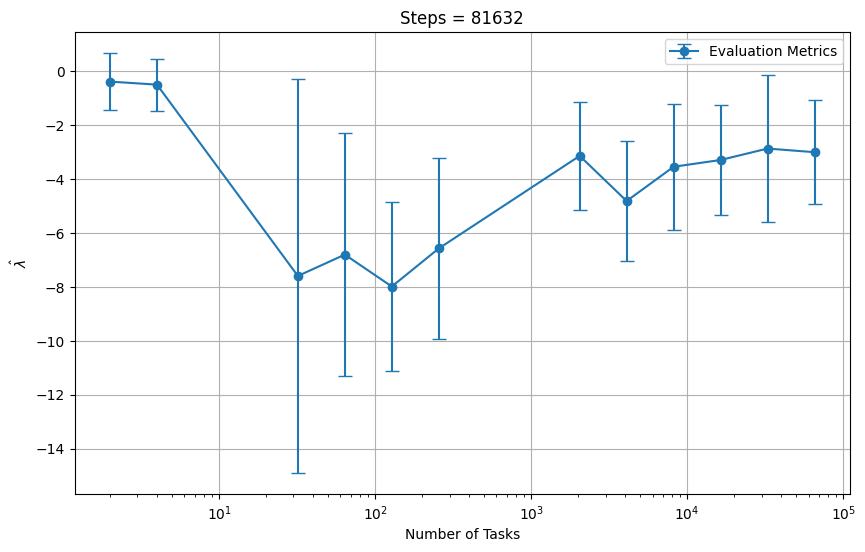

In [12]:
import matplotlib.pyplot as plt

keys = sorted(list(evals.keys()))
means = [np.mean(evals[k]) for k in keys]
std_devs = [np.std(evals[k]) for k in keys]

plt.figure(figsize=(10, 6))
plt.errorbar(keys, means, yerr=std_devs, fmt='o-', capsize=5, label="Evaluation Metrics")
plt.xlabel("Number of Tasks")
plt.ylabel(r"$\hat\lambda$")
plt.title("Steps = 81632")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.show()

In [14]:
from functools import reduce

all_steps = sorted(list(reduce(lambda x, y: x | y, [set(c.file_ids) for c in checkpointers], set())))
all_steps = all_steps[::2]
print(all_steps, len(all_steps))

[0, 2, 4, 8, 14, 24, 42, 72, 124, 211, 362, 618, 1056, 1805, 3084, 5269, 9003, 11767, 20104, 26279, 34349, 44897, 58684, 71428, 81632] 25


In [15]:
def eval_models_at_multiple_steps(steps):
    evals = {}

    for step in steps:
        print("=" * 20 + f" Step {step} " + "=" * 20)
        evals[step] = eval_models_at_step(step)

    return evals

evals_over_time = eval_models_at_multiple_steps(all_steps)

==================== Step 0 ====================
-------------------- M 1 --------------------


 10%|█         | 1/10 [00:02<00:24,  2.74s/it]

-96.0877914428711


 20%|██        | 2/10 [00:05<00:21,  2.71s/it]

-85.88005828857422


 30%|███       | 3/10 [00:08<00:18,  2.70s/it]

-77.1429443359375


 40%|████      | 4/10 [00:10<00:16,  2.70s/it]

-68.92493438720703


 50%|█████     | 5/10 [00:13<00:13,  2.70s/it]

-74.25025177001953


 60%|██████    | 6/10 [00:16<00:10,  2.70s/it]

-42.82719039916992


 70%|███████   | 7/10 [00:18<00:08,  2.71s/it]

-61.88782501220703


 80%|████████  | 8/10 [00:21<00:05,  2.71s/it]

-39.52195358276367


 90%|█████████ | 9/10 [00:24<00:02,  2.72s/it]

-32.054622650146484


100%|██████████| 10/10 [00:27<00:00,  2.71s/it]

-44.08122253417969
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:24,  2.74s/it]

-98.70574951171875


 20%|██        | 2/10 [00:05<00:21,  2.74s/it]

-71.79917907714844


 30%|███       | 3/10 [00:08<00:19,  2.74s/it]

-79.73605346679688


 40%|████      | 4/10 [00:10<00:16,  2.74s/it]

-38.13920211791992


 50%|█████     | 5/10 [00:13<00:13,  2.74s/it]

-50.62919616699219


 60%|██████    | 6/10 [00:16<00:10,  2.74s/it]

-64.07889556884766


 70%|███████   | 7/10 [00:19<00:08,  2.74s/it]

-74.05416107177734


 80%|████████  | 8/10 [00:21<00:05,  2.75s/it]

-53.29889678955078


 90%|█████████ | 9/10 [00:24<00:02,  2.75s/it]

-42.50801467895508


100%|██████████| 10/10 [00:27<00:00,  2.75s/it]

-61.418155670166016
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:24,  2.75s/it]

-105.73658752441406


 20%|██        | 2/10 [00:05<00:22,  2.75s/it]

-90.49197387695312


 30%|███       | 3/10 [00:08<00:19,  2.76s/it]

-78.27645111083984


 40%|████      | 4/10 [00:11<00:16,  2.76s/it]

-68.49138641357422


 50%|█████     | 5/10 [00:13<00:13,  2.77s/it]

-51.18134689331055


 60%|██████    | 6/10 [00:16<00:11,  2.77s/it]

-65.36212921142578


 70%|███████   | 7/10 [00:19<00:08,  2.77s/it]

-44.33072280883789


 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

-50.181427001953125


 90%|█████████ | 9/10 [00:24<00:02,  2.78s/it]

-42.44461441040039


100%|██████████| 10/10 [00:27<00:00,  2.77s/it]

-32.06973648071289
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:24,  2.78s/it]

-95.56061553955078


 20%|██        | 2/10 [00:05<00:22,  2.79s/it]

-82.07351684570312


 30%|███       | 3/10 [00:08<00:19,  2.79s/it]

-99.74422454833984


 40%|████      | 4/10 [00:11<00:16,  2.79s/it]

-62.78810119628906


 50%|█████     | 5/10 [00:13<00:13,  2.79s/it]

-56.0053596496582


 60%|██████    | 6/10 [00:16<00:11,  2.79s/it]

-67.0339584350586


 70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

-54.45597457885742


 80%|████████  | 8/10 [00:22<00:05,  2.79s/it]

-37.91646957397461


 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

-54.4449577331543


100%|██████████| 10/10 [00:27<00:00,  2.79s/it]

-37.959632873535156
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-81.33321380615234


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-80.44152069091797


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-70.8754653930664


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-68.1359634399414


 50%|█████     | 5/10 [00:13<00:13,  2.80s/it]

-65.33612823486328


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

-52.84895324707031


 70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

-56.18121337890625


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-47.340606689453125


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-45.72013854980469


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]

-36.77975845336914
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-120.2142562866211


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-62.12400436401367


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-87.28176879882812


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-70.63044738769531


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-72.09466552734375


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-63.87665557861328


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-39.565887451171875


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-50.75458526611328


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-58.573368072509766


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-39.9908561706543
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.34060668945312


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.3907470703125


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-83.86433410644531


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-59.87389373779297


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-90.15422058105469


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-54.04278564453125


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-52.079063415527344


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-47.81821823120117


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-46.0498161315918


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.08224105834961


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-43.47783660888672
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-90.39129638671875


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-82.71135711669922


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-81.5650405883789


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-79.24922180175781


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-64.96623229980469


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-65.4392318725586


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-54.582645416259766


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-61.80470275878906


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-47.93195343017578


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-45.93915557861328
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-92.76436614990234


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-84.13484191894531


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-84.64613342285156


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-76.47589874267578


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-55.33793258666992


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-48.7190055847168


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-65.86420440673828


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-50.44744873046875


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-32.02042770385742


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-50.591026306152344
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.340606689453


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-94.11920166015625


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-86.90623474121094


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-78.97090148925781


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-74.68418884277344


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-75.79553985595703


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-49.96061706542969


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-67.67102813720703


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-51.854026794433594


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-55.56220245361328


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-50.12391662597656
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:26,  2.89s/it]

-93.77440643310547


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

-81.36113739013672


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-75.61469268798828


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-76.8780746459961


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-56.54598617553711


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-60.952457427978516


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-61.34822463989258


 80%|████████  | 8/10 [00:23<00:05,  2.86s/it]

-49.97624206542969


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-58.509071350097656


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-36.7022705078125
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.34060668945312


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-101.27760314941406


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-91.16131591796875


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-63.99141311645508


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-83.38672637939453


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-64.71737670898438


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-47.22700119018555


 70%|███████   | 7/10 [00:20<00:08,  2.86s/it]

-49.96343231201172


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-66.32311248779297


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-45.930572509765625


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-42.05678939819336
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-110.95098114013672


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-95.33673095703125


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-78.65198516845703


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-80.74635314941406


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-63.79301834106445


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-59.84008026123047


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-40.189125061035156


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-60.89482116699219


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-44.783103942871094


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-41.597877502441406
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.340606689453


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-99.13917541503906


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-95.34646606445312


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-76.64163970947266


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-63.60525131225586


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-59.565860748291016


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-46.98467254638672


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-66.52035522460938


 80%|████████  | 8/10 [00:22<00:05,  2.90s/it]

-69.28407287597656


 90%|█████████ | 9/10 [00:25<00:02,  2.91s/it]

-42.57858657836914


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-44.81589126586914
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-86.31681060791016


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-88.57307434082031


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-80.59547424316406


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-61.13484191894531


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-79.9837646484375


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-51.66497802734375


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-59.503868103027344


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-50.37239456176758


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-46.22925567626953


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-26.46341323852539
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-91.516357421875


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-89.9163818359375


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-93.87328338623047


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-73.43873596191406


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-66.39894104003906


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-63.7344856262207


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-48.9400749206543


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-40.90688705444336


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-43.59003829956055


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-38.00189971923828
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.3406066894531


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-96.06884002685547


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-96.62086486816406


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-74.85286712646484


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-66.38971710205078


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-66.81071472167969


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-51.629756927490234


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-48.48999786376953


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-53.49357986450195


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-50.89893341064453


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-34.817440032958984
{1: [-96.0877914428711, -85.88005828857422, -77.1429443359375, -68.92493438720703, -74.25025177001953, -42.82719039916992, -61.88782501220703, -39.52195358276367, -32.054622650146484, -44.08122253417969], 2: [-98.70574951171875, -71.79917907714844, -79.73605346679688, -38.13920211791992, -50.62919616699219, -64.07889556884766, -74.05416107177734, -53.29889678955078, -42.50801467895508, -61.418155670166016], 4: [-105.73658752441406, -90.49197387695312, -78.27645111083984, -68.49138641357422, -51.18134689331055, -65.36212921142578, -44.33072280883789, -50.181427001953125, -42.44461441040039, -32.06973648071289], 8: [-95.56061553955078, -82.07351684570312, -99.74422454833984, -62.78810119628906, -56.0053596496582, -67.0339584350586, -54.45597457885742, -37.91646957397461, -54.4449577331543, -37.959632873535156], 16: [-81.33321380615234, -80.44152069091797, -70.8754653930664, -68.1359634399414, -65.33612823486328, -52.84895324707031, -56.18121337890625, -47.340606689453


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-90.1978988647461


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-85.26399230957031


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-77.78641510009766


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-85.64067840576172


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-53.68147277832031


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-69.89898681640625


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-53.10882568359375


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-44.5456428527832


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-51.1144905090332


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-40.85321807861328
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-114.90122985839844


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-73.32231140136719


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-75.16307830810547


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-64.91922760009766


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-72.30522918701172


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-71.11933135986328


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-52.434356689453125


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-45.26622009277344


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-42.144779205322266


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-41.610557556152344
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-104.8310546875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-64.16278839111328


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-74.17071533203125


 40%|████      | 4/10 [00:11<00:17,  2.83s/it]

-76.55838775634766


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-84.10858154296875


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-50.82554244995117


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-44.6132698059082


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-50.54863357543945


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-31.68626594543457


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-47.7353515625
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-81.61396789550781


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-77.96342468261719


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-88.85945892333984


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-49.42037582397461


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-64.88554382324219


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-60.84909439086914


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-54.593788146972656


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-51.98530578613281


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-53.02326965332031


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-46.6611442565918
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-99.87128448486328


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-71.78202056884766


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-78.91582489013672


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-73.68285369873047


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-72.78360748291016


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-61.14713668823242


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-58.5628662109375


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-29.38568878173828


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-50.87523651123047


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-52.552703857421875
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-100.4625015258789


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.66262817382812


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-65.56654357910156


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-75.30831909179688


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-60.347023010253906


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-56.17429733276367


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-71.6351089477539


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-59.379886627197266


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-43.164939880371094


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-41.844818115234375
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-110.01702117919922


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-82.72979736328125


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-86.08626556396484


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-65.80157470703125


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-65.84729766845703


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-39.49531173706055


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-57.50709915161133


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-46.22093200683594


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-55.37828063964844


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-31.578805923461914
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-85.80577087402344


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-85.84471130371094


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-100.8147201538086


 40%|████      | 4/10 [00:11<00:17,  2.83s/it]

-78.10841369628906


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-63.58296585083008


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-48.176971435546875


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-48.30812454223633


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-52.79925537109375


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-47.54937744140625


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-53.908687591552734
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-94.14097595214844


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-84.91561889648438


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-84.8231430053711


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.498897552490234


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-67.0538101196289


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-74.78178405761719


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-56.531898498535156


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-65.91812133789062


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-34.196380615234375


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-33.509613037109375
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-89.35256958007812


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-76.71131134033203


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.52461242675781


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-84.35859680175781


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-67.41051483154297


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-68.21395874023438


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-49.20148468017578


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-54.81843948364258


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-53.393035888671875


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-48.31568145751953
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-97.02790069580078


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-67.32918548583984


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-85.65668487548828


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-53.64970779418945


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-73.91301727294922


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-63.380985260009766


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-64.98057556152344


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-40.41761779785156


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-57.12093734741211


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-48.88090133666992
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-77.41908264160156


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-88.25748443603516


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-83.00363159179688


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-65.5501480102539


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.01329040527344


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-73.13518524169922


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-37.1157112121582


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-41.51424026489258


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-52.99099349975586


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-44.44164276123047
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-107.03301239013672


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-94.61640930175781


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-72.70419311523438


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-74.13677215576172


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-70.99188995361328


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-77.55369567871094


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-63.222679138183594


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-36.263465881347656


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-43.76486587524414


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-41.48952102661133
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-79.68763732910156


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-87.95085906982422


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-82.65167236328125


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.65531921386719


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-58.02070236206055


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-54.436763763427734


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-70.1578369140625


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-59.51782989501953


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-67.54717254638672


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-54.25719451904297
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-93.18856811523438


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-66.61911010742188


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-72.37169647216797


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-80.10005950927734


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-68.00993347167969


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-50.28760528564453


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-51.95866775512695


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-42.68361282348633


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-49.705223083496094


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-50.338069915771484
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -5


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-103.55793762207031


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-94.02672576904297


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-70.9518051147461


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-71.07911682128906


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-51.29597854614258


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-58.087432861328125


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-73.24559020996094


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-55.614585876464844


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-54.84418487548828


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-30.10063362121582
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-63.142242431640625


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-104.16427612304688


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-65.1349105834961


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-70.5220947265625


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-73.96924591064453


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-64.77923583984375


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-69.04148864746094


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-48.63396072387695


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-53.5367431640625


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-44.63056182861328
{1: [-90.1978988647461, -85.26399230957031, -77.78641510009766, -85.64067840576172, -53.68147277832031, -69.89898681640625, -53.10882568359375, -44.5456428527832, -51.1144905090332, -40.85321807861328], 2: [-114.90122985839844, -73.32231140136719, -75.16307830810547, -64.91922760009766, -72.30522918701172, -71.11933135986328, -52.434356689453125, -45.26622009277344, -42.144779205322266, -41.610557556152344], 4: [-104.8310546875, -64.16278839111328, -74.17071533203125, -76.55838775634766, -84.10858154296875, -50.82554244995117, -44.6132698059082, -50.54863357543945, -31.68626594543457, -47.7353515625], 8: [-81.61396789550781, -77.96342468261719, -88.85945892333984, -49.42037582397461, -64.88554382324219, -60.84909439086914, -54.593788146972656, -51.98530578613281, -53.02326965332031, -46.6611442565918], 16: [-99.87128448486328, -71.78202056884766, -78.91582489013672, -73.68285369873047, -72.78360748291016, -61.14713668823242, -58.5628662109375, -29.38568878173828, -50


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-88.43602752685547


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-88.08637237548828


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-54.664615631103516


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-74.8140640258789


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-88.53887939453125


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-57.781959533691406


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-64.0057601928711


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-50.55900573730469


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-49.0775032043457


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-39.957298278808594
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-70.45561981201172


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-79.74732208251953


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-89.28596496582031


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-72.84201049804688


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-58.92815017700195


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-55.13044357299805


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-56.90909194946289


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-45.554656982421875


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-56.906532287597656


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-43.38075256347656
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-97.3235092163086


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-86.00788116455078


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-79.31800079345703


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-52.430259704589844


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-63.12187957763672


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-61.001766204833984


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-59.185333251953125


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-57.879940032958984


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-49.147178649902344


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-50.894447326660156
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-93.87405395507812


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-96.03630828857422


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-78.12480163574219


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-70.20445251464844


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-58.43747329711914


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-68.8128662109375


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-51.83903884887695


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-37.652366638183594


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-30.28711700439453


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-45.32603454589844
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-97.28790283203125


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-71.12240600585938


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-79.98632049560547


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-71.88960266113281


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-69.57289123535156


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-39.053436279296875


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-54.34915542602539


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-66.44747924804688


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-34.472904205322266


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-51.27177429199219
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-99.67967224121094


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-88.27029418945312


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-61.8458137512207


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-76.99910736083984


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-58.32066345214844


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-58.459632873535156


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-60.394283294677734


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-52.778892517089844


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-45.287227630615234


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-50.07575988769531
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-83.59408569335938


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-76.885498046875


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-66.5906753540039


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-70.20010375976562


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-62.88172912597656


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-64.9188461303711


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-53.50075149536133


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-58.76945877075195


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-40.282108306884766


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-38.334651947021484
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.44


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-114.36073303222656


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-85.27910614013672


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.45391845703125


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-67.5636978149414


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-68.3311538696289


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-51.90205383300781


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-54.05149841308594


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-62.75505828857422


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-50.1237907409668


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-38.0214958190918
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.4474


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-91.52045440673828


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.95004272460938


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-76.28633880615234


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-71.30671691894531


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-56.5677604675293


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-72.18828582763672


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-42.89853286743164


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-51.08682632446289


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-45.17656707763672


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-40.55479431152344
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-94.05695343017578


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-82.67318725585938


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-91.95669555664062


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-78.5655288696289


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-61.17006301879883


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-78.813232421875


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-53.99001693725586


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-51.84518814086914


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-48.45989990234375


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-42.78889465332031
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-92.67829895019531


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-67.95523834228516


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-80.4256362915039


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-60.38916015625


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-62.58893585205078


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-72.51770782470703


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-49.85059356689453


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-58.482173919677734


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-48.47808837890625


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-44.908111572265625
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.44


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-82.10066986083984


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-94.45272064208984


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-67.83894348144531


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-86.76612091064453


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-61.30544662475586


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-64.67446899414062


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-59.03509521484375


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-48.11831283569336


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-47.681556701660156


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-47.1578369140625
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.4474


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-80.29141235351562


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-95.64668273925781


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-84.05722045898438


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-68.03144836425781


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-53.587974548339844


 60%|██████    | 6/10 [00:17<00:11,  2.84s/it]

-51.39178466796875


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-80.2049560546875


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-39.16486740112305


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-44.30485153198242


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-46.64590072631836
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-94.52982330322266


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-86.76048278808594


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-74.61438751220703


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-68.95144653320312


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-63.21473693847656


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-59.72160720825195


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-43.68622589111328


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-50.55952072143555


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-57.64811706542969


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-42.053585052490234
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.44


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-94.1174087524414


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.38894653320312


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-80.36774444580078


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-64.37629699707031


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-72.59430694580078


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-50.365989685058594


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-56.48514938354492


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-53.521759033203125


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-65.79158020019531


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-48.17389678955078
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-101.3662338256836


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-68.5444107055664


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-73.81670379638672


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-69.73657989501953


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-59.943058013916016


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-61.95570755004883


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-45.313228607177734


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-43.21373748779297


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-51.23885726928711


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-46.90692901611328
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-103.7326431274414


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-83.29309844970703


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-82.98109436035156


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-70.39183807373047


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-68.21524047851562


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-48.70978546142578


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-60.325374603271484


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-53.37190246582031


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-46.39524841308594


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-38.07887649536133
{1: [-88.43602752685547, -88.08637237548828, -54.664615631103516, -74.8140640258789, -88.53887939453125, -57.781959533691406, -64.0057601928711, -50.55900573730469, -49.0775032043457, -39.957298278808594], 2: [-70.45561981201172, -79.74732208251953, -89.28596496582031, -72.84201049804688, -58.92815017700195, -55.13044357299805, -56.90909194946289, -45.554656982421875, -56.906532287597656, -43.38075256347656], 4: [-97.3235092163086, -86.00788116455078, -79.31800079345703, -52.430259704589844, -63.12187957763672, -61.001766204833984, -59.185333251953125, -57.879940032958984, -49.147178649902344, -50.894447326660156], 8: [-93.87405395507812, -96.03630828857422, -78.12480163574219, -70.20445251464844, -58.43747329711914, -68.8128662109375, -51.83903884887695, -37.652366638183594, -30.28711700439453, -45.32603454589844], 16: [-97.28790283203125, -71.12240600585938, -79.98632049560547, -71.88960266113281, -69.57289123535156, -39.053436279296875, -54.34915542602539, -66.447


 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

-96.60523986816406


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-81.53583526611328


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-84.3679428100586


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-75.35494232177734


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-65.05448150634766


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-76.2611083984375


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-56.178524017333984


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-58.136741638183594


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-47.094566345214844


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-49.237220764160156
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-91.70616912841797


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-90.93205261230469


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-79.2298812866211


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-72.6027603149414


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-66.44991302490234


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-74.22040557861328


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-39.255035400390625


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-52.78324890136719


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-56.25780487060547


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-44.493900299072266
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-92.22028350830078


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-95.16741180419922


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-71.99796295166016


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-83.83679962158203


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-51.916526794433594


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-59.051876068115234


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-50.68157958984375


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-66.1171646118164


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-34.70767593383789


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-39.96050262451172
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.2160415649414


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-89.68737030029297


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-71.37549591064453


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-74.37474822998047


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-61.691864013671875


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-69.58736419677734


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-46.848907470703125


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-57.164485931396484


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-47.38518142700195


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-44.431396484375
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-94.74832916259766


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-77.43419647216797


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-88.31101989746094


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-74.05902862548828


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-59.28702926635742


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-63.783538818359375


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-55.18193054199219


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-42.950660705566406


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.14410400390625


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-41.657562255859375
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-106.34163665771484


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-86.04041290283203


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-73.5134048461914


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-78.46357727050781


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-62.72944259643555


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-67.9731674194336


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-60.88290786743164


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-48.57261276245117


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-47.89532470703125


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-37.58333206176758
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-99.80928802490234


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-101.57730865478516


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-73.47933959960938


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-72.81216430664062


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-60.91223907470703


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-61.871944427490234


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-47.1083984375


 80%|████████  | 8/10 [00:23<00:05,  2.87s/it]

-46.34222412109375


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.29831314086914


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-33.77730178833008
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-97.30762481689453


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-85.74557495117188


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-73.47370147705078


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-92.143310546875


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-72.05738830566406


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-65.71819305419922


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-54.733524322509766


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-61.5575065612793


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-31.454696655273438


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-32.370086669921875
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-109.5631103515625


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-78.92889404296875


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-72.75952911376953


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-81.08576202392578


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-64.54971313476562


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-66.25689697265625


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-49.82958984375


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-34.79592514038086


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-52.39619064331055


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-36.13679504394531
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-94.16069793701172


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-91.69208526611328


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-63.715274810791016


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-74.2496109008789


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-68.7795639038086


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-57.73149490356445


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-57.514530181884766


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-59.80472946166992


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-51.01740646362305


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-23.331851959228516
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-75.70204162597656


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-83.81079864501953


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-73.10816192626953


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-74.35425567626953


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-72.95164489746094


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-59.583152770996094


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-46.0914421081543


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-46.1356315612793


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-45.28376770019531


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-52.583953857421875
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-85.20277404785156


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-101.23738098144531


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-59.70713424682617


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-55.619327545166016


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-46.56315994262695


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-52.563331604003906


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-57.66630172729492


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-47.347267150878906


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.572021484375


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-40.9164924621582
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.95066070


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-94.94941711425781


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-68.86434936523438


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-63.541595458984375


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-65.41886901855469


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-72.4155044555664


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-50.82016372680664


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-69.76539611816406


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-35.376895904541016


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-48.28340530395508


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-37.11302185058594
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-74.2531967163086


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-79.20682525634766


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-83.61099243164062


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-97.95059204101562


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-58.00968551635742


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-51.840450286865234


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-51.46389389038086


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-48.73565673828125


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-54.6062126159668


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-42.633277893066406
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-86.51123809814453


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-76.15979766845703


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-67.41500091552734


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-78.00531005859375


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-77.45443725585938


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-52.16781997680664


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-62.848426818847656


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-52.24800109863281


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-44.60558319091797


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-44.49722671508789
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-104.67198181152344


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-85.70817565917969


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-69.23040771484375


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-66.18427276611328


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-69.30648803710938


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-55.947853088378906


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-51.72978591918945


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-46.52396774291992


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-58.03402328491211


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-52.111083984375
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.950660705


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-73.14991760253906


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-84.19811248779297


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-83.96039581298828


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-56.300968170166016


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-59.65756607055664


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-72.49645233154297


 70%|███████   | 7/10 [00:20<00:08,  2.86s/it]

-58.84630584716797


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-51.56161880493164


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-40.59142303466797


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-44.12041473388672
{1: [-96.60523986816406, -81.53583526611328, -84.3679428100586, -75.35494232177734, -65.05448150634766, -76.2611083984375, -56.178524017333984, -58.136741638183594, -47.094566345214844, -49.237220764160156], 2: [-91.70616912841797, -90.93205261230469, -79.2298812866211, -72.6027603149414, -66.44991302490234, -74.22040557861328, -39.255035400390625, -52.78324890136719, -56.25780487060547, -44.493900299072266], 4: [-92.22028350830078, -95.16741180419922, -71.99796295166016, -83.83679962158203, -51.916526794433594, -59.051876068115234, -50.68157958984375, -66.1171646118164, -34.70767593383789, -39.96050262451172], 8: [-84.2160415649414, -89.68737030029297, -71.37549591064453, -74.37474822998047, -61.691864013671875, -69.58736419677734, -46.848907470703125, -57.164485931396484, -47.38518142700195, -44.431396484375], 16: [-94.74832916259766, -77.43419647216797, -88.31101989746094, -74.05902862548828, -59.28702926635742, -63.783538818359375, -55.18193054199219, -42.9506607


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-83.30052185058594


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-105.54369354248047


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-56.59632110595703


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-78.774169921875


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-57.040504455566406


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-46.98057556152344


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-55.79645919799805


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-62.148983001708984


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-52.92656707763672


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-48.90766906738281
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-105.98992919921875


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-83.03385925292969


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-66.78150939941406


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-70.36161041259766


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-56.8018913269043


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-74.07746887207031


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-42.66273498535156


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-44.6132698059082


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-47.036800384521484


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-44.33559036254883
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-85.71073913574219


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-83.54029083251953


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.6040267944336


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-70.98356628417969


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-64.83380126953125


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-57.428714752197266


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-51.90987014770508


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-61.784080505371094


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-46.7387580871582


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-47.63032531738281
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-106.17666625976562


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.70223236083984


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-62.07584762573242


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-68.3914794921875


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-79.75218963623047


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-51.86235046386719


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-44.02525329589844


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-35.9632453918457


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-47.78632736206055


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-40.56106948852539
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-89.09205627441406


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-75.59317016601562


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-68.19500732421875


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-78.66761016845703


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-73.24713134765625


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-57.63543701171875


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-63.72283172607422


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-57.74225616455078


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-42.44371795654297


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-44.16460418701172
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-97.42366790771484


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-73.2905502319336


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-71.28353118896484


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-63.7162971496582


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-71.8806381225586


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-52.68065643310547


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-69.21797943115234


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-49.38246154785156


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-47.5194091796875


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-43.403038024902344
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.7422561645


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-118.10579681396484


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-88.15348052978516


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-82.02458953857422


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-67.15025329589844


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-52.92003631591797


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-58.24637985229492


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-52.82743453979492


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-47.661319732666016


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-48.73078918457031


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-42.2437858581543
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.742256164550


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-87.95137023925781


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-80.0936508178711


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-82.75413513183594


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-87.09720611572266


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-73.2230453491211


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-66.35205841064453


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-53.87346649169922


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-52.00516128540039


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-39.71023178100586


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-39.15218734741211
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-107.68289184570312


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-75.5242691040039


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-83.36712646484375


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-56.5911979675293


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-59.74120330810547


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-55.003902435302734


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-60.40478515625


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-55.75739669799805


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-44.37977981567383


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-48.53675079345703
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-96.88624572753906


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-87.60990905761719


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-71.40571594238281


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-53.306453704833984


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-64.7186508178711


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-54.044837951660156


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-65.52619934082031


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-44.944740295410156


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-45.37073516845703


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-52.76723861694336
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-97.67547607421875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-69.85057067871094


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-64.29855346679688


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-84.86784362792969


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-60.58653259277344


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-62.38580322265625


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-52.63941192626953


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-48.51472091674805


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-50.39352798461914


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-52.38351058959961
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.88s/it]

-91.5637435913086


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-81.05143737792969


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-65.57038879394531


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-63.44566345214844


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-61.29878616333008


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-64.4843978881836


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-53.50254440307617


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-52.211368560791016


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-45.877803802490234


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-51.35002899169922
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-85.84624481201172


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-67.69882202148438


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-84.6566390991211


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.2453384399414


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-85.81499481201172


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-50.13365173339844


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-60.792484283447266


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-59.262821197509766


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-47.96820068359375


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-32.147098541259766
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.7422561645


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-82.94164276123047


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-110.38845825195312


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.48430633544922


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-59.535762786865234


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-73.81029510498047


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-63.50880813598633


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-60.66453170776367


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-55.519168853759766


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-43.55750274658203


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-43.035064697265625
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.7422561645


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-107.17671966552734


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-104.685302734375


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-53.12150573730469


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-63.07038879394531


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-50.99896240234375


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-56.7910041809082


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-59.793331146240234


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-40.88395690917969


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-54.955360412597656


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-34.72573471069336
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-91.02503967285156


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-85.17869567871094


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-86.25891876220703


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.89303588867188


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-70.45369720458984


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-62.10171890258789


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-45.03478240966797


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-50.90674591064453


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-55.323974609375


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-39.93872833251953
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-99.6041030883789


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-78.66376495361328


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.3724594116211


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-68.84232330322266


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-68.40838623046875


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-53.29838562011719


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-61.870277404785156


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-49.61608123779297


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-44.54128646850586


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-31.60544776916504
{1: [-83.30052185058594, -105.54369354248047, -56.59632110595703, -78.774169921875, -57.040504455566406, -46.98057556152344, -55.79645919799805, -62.148983001708984, -52.92656707763672, -48.90766906738281], 2: [-105.98992919921875, -83.03385925292969, -66.78150939941406, -70.36161041259766, -56.8018913269043, -74.07746887207031, -42.66273498535156, -44.6132698059082, -47.036800384521484, -44.33559036254883], 4: [-85.71073913574219, -83.54029083251953, -82.6040267944336, -70.98356628417969, -64.83380126953125, -57.428714752197266, -51.90987014770508, -61.784080505371094, -46.7387580871582, -47.63032531738281], 8: [-106.17666625976562, -84.70223236083984, -62.07584762573242, -68.3914794921875, -79.75218963623047, -51.86235046386719, -44.02525329589844, -35.9632453918457, -47.78632736206055, -40.56106948852539], 16: [-89.09205627441406, -75.59317016601562, -68.19500732421875, -78.66761016845703, -73.24713134765625, -57.63543701171875, -63.72283172607422, -57.74225616455


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-101.47945404052734


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-89.34821319580078


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-69.48118591308594


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.3056640625


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-59.52846145629883


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-67.58675384521484


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-60.67068099975586


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-45.72795104980469


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-60.51173400878906


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-40.241764068603516
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-90.11515808105469


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-69.11641693115234


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-80.09902954101562


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-56.63820266723633


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-68.78058624267578


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-64.2128677368164


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-63.689144134521484


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-61.937522888183594


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-41.188148498535156


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-44.659122467041016
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-96.37751007080078


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-99.01596069335938


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-68.80133819580078


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-66.3956069946289


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-68.98538970947266


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-60.231876373291016


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-68.44744873046875


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-46.67266845703125


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-51.41688919067383


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-28.296239852905273
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-78.57539367675781


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.94840240478516


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-91.66954040527344


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-72.1640853881836


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-74.62129974365234


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-49.959720611572266


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-52.22712326049805


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-32.82733154296875


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-52.044734954833984


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-39.857139587402344
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-92.09323120117188


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.76022338867188


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-84.21424865722656


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-60.1625862121582


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.62435913085938


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-48.452857971191406


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-43.09090805053711


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-55.2119026184082


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-40.954402923583984


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-50.32872009277344
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-75.35673522949219


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.54981994628906


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-73.23777770996094


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-71.95902252197266


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-63.42850112915039


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-45.59449005126953


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-63.510345458984375


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-74.89449310302734


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-49.65424728393555


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-45.48536682128906
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-79.37742614746094


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-81.12674713134766


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-73.68580627441406


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-74.71902465820312


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-57.84343719482422


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

-54.93653106689453


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-54.21672058105469


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-56.113460540771484


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-43.94071960449219


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-40.99538803100586
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-93.66886901855469


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-75.42179870605469


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-85.63005065917969


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-57.06816864013672


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-64.15702056884766


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-71.30838012695312


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-53.623069763183594


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-62.07725524902344


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-39.111968994140625


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-39.3608283996582
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.21190261


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-86.66288757324219


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-80.39336395263672


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-80.68333435058594


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-54.69087219238281


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-63.562347412109375


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-56.93061065673828


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-50.27389907836914


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-62.850990295410156


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-59.96803283691406


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-43.734127044677734
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.211902


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-112.81608581542969


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-92.54689025878906


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-82.77257537841797


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-69.60696411132812


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-69.76577758789062


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-57.792205810546875


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-61.73617935180664


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-52.57511520385742


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-37.16438293457031


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-64.05276489257812
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-92.92139434814453


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-69.17533111572266


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-85.96638488769531


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-75.19664001464844


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-65.98857116699219


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-66.84273529052734


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-38.32811737060547


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-45.57579040527344


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-46.42086410522461


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-56.67201614379883
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-90.02294158935547


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-82.5702133178711


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-64.00140380859375


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-80.83562469482422


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-53.83375930786133


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-68.40198516845703


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-59.60274887084961


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-52.436279296875


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-46.86491775512695


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-38.96992874145508
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-108.71854400634766


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-92.73900604248047


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-81.5447998046875


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-76.58028411865234


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-61.44723129272461


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-46.95547103881836


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-57.66169357299805


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-50.5998649597168


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-46.32365036010742


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-47.07625198364258
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-104.8912582397461


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-89.48218536376953


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-46.68624496459961


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-75.18959045410156


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-71.7052993774414


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-53.464378356933594


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-57.17409133911133


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-37.774173736572266


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-56.823150634765625


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-53.69748306274414
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-92.14395141601562


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-74.46273803710938


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-65.20638275146484


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-66.38728332519531


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-60.92082214355469


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-63.638423919677734


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-53.355125427246094


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-55.85383987426758


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-55.692588806152344


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-56.44095993041992
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-82.2003173828125


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-91.41030883789062


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-85.26629638671875


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-78.35304260253906


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-66.17198181152344


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-53.632545471191406


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-70.10749816894531


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-48.65471267700195


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-39.51094055175781


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-46.96097946166992
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-99.23190307617188


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-91.62752532958984


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-87.89373779296875


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-66.93534088134766


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-51.76308822631836


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-51.91307067871094


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-48.89473342895508


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-52.98855972290039


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-54.699581146240234


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-50.18398666381836
{1: [-101.47945404052734, -89.34821319580078, -69.48118591308594, -73.3056640625, -59.52846145629883, -67.58675384521484, -60.67068099975586, -45.72795104980469, -60.51173400878906, -40.241764068603516], 2: [-90.11515808105469, -69.11641693115234, -80.09902954101562, -56.63820266723633, -68.78058624267578, -64.2128677368164, -63.689144134521484, -61.937522888183594, -41.188148498535156, -44.659122467041016], 4: [-96.37751007080078, -99.01596069335938, -68.80133819580078, -66.3956069946289, -68.98538970947266, -60.231876373291016, -68.44744873046875, -46.67266845703125, -51.41688919067383, -28.296239852905273], 8: [-78.57539367675781, -84.94840240478516, -91.66954040527344, -72.1640853881836, -74.62129974365234, -49.959720611572266, -52.22712326049805, -32.82733154296875, -52.044734954833984, -39.857139587402344], 16: [-92.09323120117188, -86.76022338867188, -84.21424865722656, -60.1625862121582, -66.62435913085938, -48.452857971191406, -43.09090805053711, -55.2119026


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-107.09039306640625


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-100.51860046386719


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-78.99984741210938


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-60.81156921386719


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-55.88867950439453


 60%|██████    | 6/10 [00:17<00:11,  2.84s/it]

-51.531646728515625


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-59.78167724609375


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-55.639305114746094


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-45.78699493408203


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-37.8784294128418
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

-100.55779266357422


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-69.22579193115234


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-71.65496063232422


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-78.18115997314453


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-76.99897766113281


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-47.4229621887207


 70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

-45.47114944458008


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-50.471527099609375


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-53.71989822387695


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-51.151123046875
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.72119140625


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.24406433105469


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-86.72640991210938


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-80.64208984375


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-68.04886627197266


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-59.27934646606445


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-56.56327819824219


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-48.707481384277344


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-50.016971588134766


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-33.377437591552734
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-103.31561279296875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-80.53706359863281


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-71.3281021118164


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-74.90461730957031


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-62.93218994140625


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-57.32958221435547


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-65.0380859375


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-51.99068832397461


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-53.93507385253906


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-46.85761642456055
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-88.92913818359375


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-73.05001068115234


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-79.27701568603516


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-68.91789245605469


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-62.33584976196289


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-69.55419158935547


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-49.052913665771484


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-53.86180877685547


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-43.01546859741211


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-51.321468353271484
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-90.21199035644531


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-64.66896057128906


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-84.07361602783203


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-75.23774719238281


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-82.61196899414062


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-71.75743103027344


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-56.87989044189453


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-56.07772445678711


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.73724365234375


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-36.771175384521484
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-103.59354400634766


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-99.85872650146484


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-63.992950439453125


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-70.72932434082031


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-71.56517791748047


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-64.29329681396484


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-43.68327713012695


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-48.05376052856445


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-45.491641998291016


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-38.460296630859375
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-96.38186645507812


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-87.93215942382812


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-95.0357437133789


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-87.54779052734375


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-77.54229736328125


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-35.982460021972656


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-46.0805549621582


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-51.146636962890625


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-43.71337890625


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-45.29939270019531
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-101.98562622070312


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-80.99662017822266


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-72.52206420898438


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-63.265201568603516


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.98695373535156


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-58.96670150756836


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-62.45458221435547


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-44.706382751464844


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-55.2745361328125


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-29.006059646606445
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-98.45702362060547


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-83.53721618652344


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-76.8104476928711


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-78.31769561767578


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-58.1828498840332


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-67.53731536865234


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-59.5283317565918


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-47.7797966003418


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-50.4042854309082


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-35.162235260009766
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-72.03228759765625


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-77.05815124511719


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-81.03683471679688


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-72.49055480957031


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-74.3155746459961


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-62.950252532958984


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-56.308013916015625


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-66.24588012695312


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-37.342926025390625


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-45.21601486206055
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-89.1745376586914


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-89.01136016845703


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-86.2202377319336


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-79.37102508544922


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-63.30605697631836


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-64.61682891845703


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-56.852352142333984


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-58.628570556640625


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-42.25954055786133


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-33.636287689208984
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-75.73175811767578


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-89.99118041992188


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-71.51612091064453


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-66.01610565185547


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-78.37328338623047


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-63.06411361694336


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-39.5535888671875


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-68.73947143554688


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-56.43391799926758


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-32.09253692626953
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-102.07015991210938


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-90.83138275146484


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-86.68901062011719


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-70.24723815917969


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-69.01676940917969


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-75.90235900878906


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-54.842777252197266


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-35.903690338134766


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-32.76431655883789


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-30.996938705444336
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-89.31132507324219


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-97.43878173828125


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-77.1580581665039


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-74.33875274658203


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-64.50360870361328


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-65.58370971679688


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-38.75244903564453


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-45.515594482421875


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-52.06843185424805


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-47.73752975463867
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-86.24662780761719


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-80.45458221435547


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-78.82950592041016


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.45048141479492


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-40.81774139404297


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-53.67570877075195


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-59.74030685424805


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-56.421749114990234


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-49.15742492675781


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-43.773189544677734
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-70.88801574707031


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-96.65467834472656


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-77.39500427246094


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-73.6148452758789


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-76.17401885986328


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-59.49592971801758


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-46.03598403930664


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-59.04188537597656


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-52.25325012207031


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-38.34515380859375
{1: [-107.09039306640625, -100.51860046386719, -78.99984741210938, -60.81156921386719, -55.88867950439453, -51.531646728515625, -59.78167724609375, -55.639305114746094, -45.78699493408203, -37.8784294128418], 2: [-100.55779266357422, -69.22579193115234, -71.65496063232422, -78.18115997314453, -76.99897766113281, -47.4229621887207, -45.47114944458008, -50.471527099609375, -53.71989822387695, -51.151123046875], 4: [-84.72119140625, -86.24406433105469, -86.72640991210938, -80.64208984375, -68.04886627197266, -59.27934646606445, -56.56327819824219, -48.707481384277344, -50.016971588134766, -33.377437591552734], 8: [-103.31561279296875, -80.53706359863281, -71.3281021118164, -74.90461730957031, -62.93218994140625, -57.32958221435547, -65.0380859375, -51.99068832397461, -53.93507385253906, -46.85761642456055], 16: [-88.92913818359375, -73.05001068115234, -79.27701568603516, -68.91789245605469, -62.33584976196289, -69.55419158935547, -49.052913665771484, -53.86180877685547,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-87.16521453857422


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-94.43453216552734


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-97.40650939941406


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.293582916259766


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.06887817382812


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-63.78379821777344


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-50.014793395996094


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-51.58198165893555


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-31.270389556884766


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-45.9791145324707
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-69.89949798583984


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-94.29415893554688


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.19791412353516


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-65.8622817993164


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-65.02527618408203


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-62.69947052001953


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-51.6899528503418


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-44.300113677978516


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-31.4262638092041


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-29.99586296081543
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-82.55638122558594


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-85.52425384521484


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-80.08930206298828


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-79.26087951660156


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-67.27103424072266


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-58.84297561645508


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-64.10233306884766


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-41.4735107421875


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-41.19288635253906


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-46.15291976928711
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-96.72921752929688


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-76.93083953857422


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.5884017944336


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.558326721191406


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-60.47856140136719


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-47.20484161376953


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-62.75467300415039


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-54.660518646240234


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-52.9178581237793


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-38.89986801147461
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

-84.1494369506836


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-85.9256591796875


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-76.18080139160156


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-65.6447982788086


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-60.26415252685547


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-68.65289306640625


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-65.23917388916016


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-48.18503952026367


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-46.850955963134766


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-50.838348388671875
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-90.03933715820312


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-87.28176879882812


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-67.38220977783203


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.1007308959961


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-67.65502166748047


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-64.74606323242188


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-54.827152252197266


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-54.153831481933594


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-49.104400634765625


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-35.79533386230469
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-90.62338256835938


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.04389953613281


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-71.55736541748047


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-70.74495697021484


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-60.50251007080078


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-59.0595588684082


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-72.10247802734375


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-28.254228591918945


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-61.68917465209961


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-40.9768180847168
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367, 


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-96.16336059570312


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.13125610351562


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-73.04975891113281


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-75.9228515625


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-65.03091430664062


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-79.11319732666016


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-58.107666015625


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-58.06693649291992


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-38.94597625732422


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-35.96043014526367
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-98.8522720336914


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-75.78631591796875


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-76.98463439941406


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-77.47697448730469


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-59.70405960083008


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-60.387752532958984


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-47.85664367675781


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-48.1102409362793


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-40.83900451660156


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-47.829490661621094
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-85.80065155029297


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-89.54341125488281


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-78.84077453613281


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-57.3922119140625


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-59.78001022338867


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-73.70526885986328


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-52.76774978637695


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-43.7865104675293


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-45.0971565246582


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-33.1306266784668
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367, 


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-85.40462493896484


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-88.65453338623047


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-61.399070739746094


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-71.28968048095703


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.31965637207031


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-61.690582275390625


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-52.946292877197266


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-45.73115158081055


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-59.28178024291992


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-45.79608917236328
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-83.42630004882812


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-103.43933868408203


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-63.75728225708008


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-86.28556060791016


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-66.60975646972656


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-63.3026008605957


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-54.20365524291992


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-64.63655090332031


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-54.84239196777344


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-33.72389221191406
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-91.33345794677734


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-95.17073822021484


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.0232162475586


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-75.53438568115234


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-60.20997619628906


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-64.29508972167969


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-68.85231018066406


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-51.27215576171875


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-46.905391693115234


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-37.43091583251953
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-92.56251525878906


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-78.63456726074219


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-62.07789611816406


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-86.53314208984375


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-50.61190414428711


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-60.59152603149414


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-65.15707397460938


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-53.69709777832031


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-48.34757614135742


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-49.617618560791016
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-82.33710479736328


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-89.0625991821289


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-94.0741195678711


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.98432159423828


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-76.54698944091797


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-55.70539474487305


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-71.46220397949219


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-49.77016067504883


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-38.7395133972168


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-43.524845123291016
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-82.17444610595703


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-102.8637466430664


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-92.57942199707031


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-78.67938995361328


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-64.88874053955078


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-60.72908401489258


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-56.13549041748047


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-45.96797180175781


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-45.21281051635742


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-40.14839553833008
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-94.69786834716797


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-104.70964050292969


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.85292053222656


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-62.997257232666016


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-74.00305938720703


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-67.11951446533203


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-58.31746292114258


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-52.706783294677734


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-49.44919204711914


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-41.883113861083984
{1: [-87.16521453857422, -94.43453216552734, -97.40650939941406, -62.293582916259766, -66.06887817382812, -63.78379821777344, -50.014793395996094, -51.58198165893555, -31.270389556884766, -45.9791145324707], 2: [-69.89949798583984, -94.29415893554688, -75.19791412353516, -65.8622817993164, -65.02527618408203, -62.69947052001953, -51.6899528503418, -44.300113677978516, -31.4262638092041, -29.99586296081543], 4: [-82.55638122558594, -85.52425384521484, -80.08930206298828, -79.26087951660156, -67.27103424072266, -58.84297561645508, -64.10233306884766, -41.4735107421875, -41.19288635253906, -46.15291976928711], 8: [-96.72921752929688, -76.93083953857422, -82.5884017944336, -62.558326721191406, -60.47856140136719, -47.20484161376953, -62.75467300415039, -54.660518646240234, -52.9178581237793, -38.89986801147461], 16: [-84.1494369506836, -85.9256591796875, -76.18080139160156, -65.6447982788086, -60.26415252685547, -68.65289306640625, -65.23917388916016, -48.18503952026367


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-81.91290283203125


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-91.91110229492188


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-68.99729919433594


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-72.96471405029297


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-82.94407653808594


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-61.58120346069336


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-58.04708480834961


 80%|████████  | 8/10 [00:22<00:05,  2.83s/it]

-54.98622512817383


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-53.90036392211914


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-42.29655456542969
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-83.00747680664062


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-81.15415954589844


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.95128631591797


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-64.64500427246094


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-79.44851684570312


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-58.93826675415039


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-61.301475524902344


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-50.665184020996094


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-38.052490234375


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-44.884925842285156
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-82.2705078125


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-102.75462341308594


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-83.08099365234375


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-79.92330932617188


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-73.03349304199219


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-57.926048278808594


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-58.40314865112305


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-56.69392013549805


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-50.93492126464844


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-33.41291427612305
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-93.32074737548828


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-94.82774353027344


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-76.0742416381836


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-63.71757888793945


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-61.77447509765625


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-51.86311721801758


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-67.306640625


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-64.75093078613281


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-43.69173049926758


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-47.810020446777344
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-101.09547424316406


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-85.88748931884766


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-68.79313659667969


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-77.19647979736328


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-73.07280731201172


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-50.57924270629883


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-46.159454345703125


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-47.18230056762695


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-41.01114273071289


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-49.136932373046875
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-89.91996765136719


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.81622314453125


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-73.26339721679688


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-83.7123031616211


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-63.20346450805664


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-54.82804870605469


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-47.9512939453125


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-48.92201232910156


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-48.17108154296875


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-36.98237991333008
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-84.80342102050781


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-92.35323333740234


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-92.25358581542969


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-73.7302474975586


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-54.909889221191406


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-62.79616928100586


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-57.45420455932617


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-54.224788665771484


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-57.197784423828125


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-50.49279022216797
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-105.6067123413086


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-81.46513366699219


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-82.48875427246094


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-71.42134857177734


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-69.17469024658203


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

-53.101783752441406


 70%|███████   | 7/10 [00:19<00:08,  2.80s/it]

-52.9407844543457


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-37.21305465698242


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-59.264488220214844


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-37.344974517822266
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-105.79114532470703


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-71.76639556884766


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-77.67498779296875


 40%|████      | 4/10 [00:11<00:16,  2.80s/it]

-66.40726470947266


 50%|█████     | 5/10 [00:14<00:14,  2.80s/it]

-61.81379699707031


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-53.31913375854492


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-60.028358459472656


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-43.73899459838867


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-40.57182693481445


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-29.45331573486328
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-90.13232421875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.08267974853516


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-69.76885223388672


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-66.6900634765625


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-80.15897369384766


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-71.27892303466797


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-47.754817962646484


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-52.643768310546875


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-45.505859375


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-42.87624740600586
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-82.41267395019531


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-105.58084106445312


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-60.2957878112793


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-64.59941101074219


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-77.34658813476562


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-62.23402786254883


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-60.774295806884766


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-39.78438949584961


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-23.352088928222656


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-40.73692321777344
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-110.26831817626953


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-99.85053253173828


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-85.12669372558594


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-73.14363861083984


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-62.7359733581543


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-66.2499771118164


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-54.26423645019531


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-44.936798095703125


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-49.47737121582031


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-62.877628326416016
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-79.10026550292969


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-76.77202606201172


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-70.92337036132812


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-70.51709747314453


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-70.49788665771484


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-60.41259765625


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-51.501163482666016


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-47.862022399902344


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-49.32892608642578


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-44.16421890258789
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-102.1124267578125


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-89.98656463623047


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-53.398414611816406


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-64.61157989501953


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-74.07183837890625


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-63.593597412109375


 70%|███████   | 7/10 [00:19<00:08,  2.83s/it]

-72.14410400390625


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-56.327354431152344


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-40.87870788574219


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-51.36412048339844
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-94.2193603515625


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-83.28028869628906


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-61.5491828918457


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-83.0797119140625


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-54.85532760620117


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

-70.00157928466797


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-47.08367919921875


 80%|████████  | 8/10 [00:22<00:05,  2.82s/it]

-38.971466064453125


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-36.99928665161133


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-45.42580795288086
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695,


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-94.53238677978516


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-84.09667205810547


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-74.79267120361328


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-67.28397369384766


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-66.08937072753906


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-66.16058349609375


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-57.91529083251953


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-60.591270446777344


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-50.52608871459961


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-38.308780670166016
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-96.96488952636719


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-93.75263214111328


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-71.67033386230469


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-74.48540496826172


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-58.71207809448242


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-55.97897720336914


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-34.23518753051758


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-53.815574645996094


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-32.18833923339844


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-50.874210357666016
{1: [-81.91290283203125, -91.91110229492188, -68.99729919433594, -72.96471405029297, -82.94407653808594, -61.58120346069336, -58.04708480834961, -54.98622512817383, -53.90036392211914, -42.29655456542969], 2: [-83.00747680664062, -81.15415954589844, -75.95128631591797, -64.64500427246094, -79.44851684570312, -58.93826675415039, -61.301475524902344, -50.665184020996094, -38.052490234375, -44.884925842285156], 4: [-82.2705078125, -102.75462341308594, -83.08099365234375, -79.92330932617188, -73.03349304199219, -57.926048278808594, -58.40314865112305, -56.69392013549805, -50.93492126464844, -33.41291427612305], 8: [-93.32074737548828, -94.82774353027344, -76.0742416381836, -63.71757888793945, -61.77447509765625, -51.86311721801758, -67.306640625, -64.75093078613281, -43.69173049926758, -47.810020446777344], 16: [-101.09547424316406, -85.88748931884766, -68.79313659667969, -77.19647979736328, -73.07280731201172, -50.57924270629883, -46.159454345703125, -47.18230056762695


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-84.89435577392578


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-65.7535400390625


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-86.47870635986328


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-76.11420440673828


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-56.636539459228516


 60%|██████    | 6/10 [00:16<00:11,  2.83s/it]

-72.0335693359375


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-59.518470764160156


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-52.94975280761719


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-44.20994567871094


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-45.811073303222656
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-84.55493927001953


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-84.43736267089844


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-84.88692474365234


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-67.77835845947266


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-68.58001708984375


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-42.19357681274414


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-30.461946487426758


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-46.173927307128906


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-51.21272659301758


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-53.143280029296875
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-98.36890411376953


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-73.07793426513672


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-78.3427963256836


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-55.90571212768555


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-64.02112579345703


 60%|██████    | 6/10 [00:16<00:11,  2.85s/it]

-63.74678039550781


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-42.920047760009766


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-47.93246841430664


 90%|█████████ | 9/10 [00:25<00:02,  2.84s/it]

-48.14149475097656


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-36.50476837158203
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-102.75487518310547


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-83.15733337402344


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.73098754882812


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-75.21751403808594


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-61.38485336303711


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-71.3437271118164


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-61.42673873901367


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-43.4795036315918


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-56.75040054321289


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-43.632816314697266
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-79.95276641845703


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-77.27999114990234


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-70.66182708740234


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-69.2989273071289


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-57.02872085571289


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-55.93069076538086


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-66.81775665283203


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-55.240848541259766


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-48.12804412841797


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-48.35807800292969
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-65.54451751708984


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-87.36835479736328


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-77.20185852050781


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-73.74215698242188


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-48.638572692871094


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-56.1853141784668


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-49.767086029052734


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-51.65293884277344


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-44.962799072265625


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-51.16085433959961
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-97.81098175048828


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-77.94574737548828


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-84.23628234863281


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-55.088050842285156


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-60.768531799316406


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-56.68162155151367


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-49.0805778503418


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-55.453590393066406


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-48.4843635559082


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-43.61488342285156
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-71.45233917236328


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-89.54571533203125


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-93.92913055419922


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-61.39842987060547


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-72.6652603149414


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-53.07796096801758


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-49.702789306640625


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-61.4326286315918


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-52.04780960083008


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-44.63837432861328
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-75.31139373779297


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-80.09288787841797


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-81.00865936279297


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-53.82107925415039


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-64.67241668701172


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-61.202980041503906


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-52.08597946166992


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-54.94997787475586


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-47.829490661621094


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-51.32992172241211
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-110.6297607421875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-77.42932891845703


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-64.38129425048828


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-84.46502685546875


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-59.38180923461914


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-70.72382354736328


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-61.19029998779297


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-46.67151641845703


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-35.13008499145508


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-45.322959899902344
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.2408485


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-103.80104064941406


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-87.9444580078125


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-108.15960693359375


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-75.23249816894531


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-51.500267028808594


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-67.6474609375


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-54.39295959472656


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-47.513004302978516


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-50.10316848754883


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-42.3345947265625
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.240848541


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-66.51997375488281


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-86.18309783935547


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-85.35365295410156


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-67.42511749267578


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-52.50621032714844


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-63.601409912109375


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-63.77790451049805


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-45.87844467163086


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.96971130371094


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-42.15131378173828
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-99.60948181152344


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-76.82120513916016


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-83.47010040283203


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-75.98855590820312


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-74.38101959228516


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-65.10955810546875


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-42.02873992919922


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

-59.490291595458984


 90%|█████████ | 9/10 [00:25<00:02,  2.80s/it]

-47.594974517822266


100%|██████████| 10/10 [00:28<00:00,  2.81s/it]

-35.87371826171875
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-91.70565795898438


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-87.42700958251953


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-75.40847778320312


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-66.8976821899414


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-66.99925231933594


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-45.28402328491211


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-51.16047286987305


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-46.82188415527344


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-48.5469970703125


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-39.161407470703125
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.2408485


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-91.88497161865234


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-71.12189483642578


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-58.10818099975586


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-68.44181823730469


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-64.7228775024414


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-64.90398406982422


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-55.17719268798828


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-63.59500503540039


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-45.90854263305664


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-23.401655197143555
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.2408485


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-99.51496124267578


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-77.5935287475586


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-82.65320587158203


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-80.63031005859375


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-74.81444549560547


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-56.63576889038086


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-42.574615478515625


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-60.753292083740234


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-63.99576950073242


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-41.61414337158203
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.24084854


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-108.47852325439453


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-88.5927963256836


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-72.84713745117188


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-77.73621368408203


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-46.779232025146484


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-42.60240936279297


 70%|███████   | 7/10 [00:20<00:08,  2.86s/it]

-60.13440704345703


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-58.519187927246094


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-41.496437072753906


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-52.923622131347656
{1: [-84.89435577392578, -65.7535400390625, -86.47870635986328, -76.11420440673828, -56.636539459228516, -72.0335693359375, -59.518470764160156, -52.94975280761719, -44.20994567871094, -45.811073303222656], 2: [-84.55493927001953, -84.43736267089844, -84.88692474365234, -67.77835845947266, -68.58001708984375, -42.19357681274414, -30.461946487426758, -46.173927307128906, -51.21272659301758, -53.143280029296875], 4: [-98.36890411376953, -73.07793426513672, -78.3427963256836, -55.90571212768555, -64.02112579345703, -63.74678039550781, -42.920047760009766, -47.93246841430664, -48.14149475097656, -36.50476837158203], 8: [-102.75487518310547, -83.15733337402344, -75.73098754882812, -75.21751403808594, -61.38485336303711, -71.3437271118164, -61.42673873901367, -43.4795036315918, -56.75040054321289, -43.632816314697266], 16: [-79.95276641845703, -77.27999114990234, -70.66182708740234, -69.2989273071289, -57.02872085571289, -55.93069076538086, -66.81775665283203, -55.2408485


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-71.93904876708984


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-82.38705444335938


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-57.84920120239258


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-66.54328155517578


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-64.89732360839844


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-52.56640625


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-59.98289108276367


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-54.11784362792969


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-52.56653594970703


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-32.88176727294922
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.46707916259766


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-78.3115463256836


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-82.31942749023438


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-72.52104187011719


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-55.44731521606445


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-54.52923583984375


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-50.225101470947266


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-42.228546142578125


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-49.73891067504883


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-34.63915252685547
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-91.83604431152344


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-72.62504577636719


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-74.85005187988281


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-73.82886505126953


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-60.259159088134766


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-61.839412689208984


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-45.28748321533203


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-58.97669219970703


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-49.427032470703125


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-47.38197708129883
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-83.04129028320312


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-95.55062103271484


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-73.90635681152344


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-82.02843475341797


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-39.62467575073242


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-56.017398834228516


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-42.7271614074707


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-35.84605407714844


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-48.700565338134766


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-39.00310134887695
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-75.99918365478516


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-78.60356903076172


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-72.32994842529297


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-80.53553009033203


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-69.41202545166016


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-50.072303771972656


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-47.85331344604492


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-49.572662353515625


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-44.01013946533203


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-28.554576873779297
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-85.58650207519531


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-75.81039428710938


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-86.61447143554688


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-61.281494140625


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-71.6614990234375


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-63.458343505859375


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-63.2354850769043


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-49.342247009277344


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-46.60760498046875


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-50.17988967895508
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.57266235351


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-84.03621673583984


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-75.37492370605469


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-74.62488555908203


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-90.84149932861328


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-51.084007263183594


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-53.67237854003906


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-59.31507873535156


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-50.36432647705078


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-47.51979064941406


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-38.183773040771484
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-90.70074462890625


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-91.16925811767578


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-87.83943176269531


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-69.93791961669922


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-77.18892669677734


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-67.64964294433594


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-54.4969596862793


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-47.51607894897461


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-51.46184539794922


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-31.816139221191406
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-94.44554901123047


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-97.85478973388672


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-79.93508911132812


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-64.24604034423828


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-54.655906677246094


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-52.321388244628906


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-57.34840774536133


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-40.33936309814453


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-55.97282791137695


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-45.735633850097656
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-96.80683135986328


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-86.58450317382812


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-78.26620483398438


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-73.8281021118164


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-73.12020111083984


 60%|██████    | 6/10 [00:17<00:11,  2.84s/it]

-49.54486846923828


 70%|███████   | 7/10 [00:19<00:08,  2.84s/it]

-47.526710510253906


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-40.28761672973633


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-38.630516052246094


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-49.271034240722656
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-87.25077056884766


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-90.00244903564453


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-74.44377899169922


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-90.62235260009766


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-74.49872589111328


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-55.60869598388672


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-60.333316802978516


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-42.09585189819336


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-39.64606475830078


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-60.04116439819336
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.57266235351


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-87.343505859375


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-81.62446594238281


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-66.48052215576172


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

-87.31314849853516


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-60.04872131347656


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-74.98017883300781


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-58.046443939208984


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-44.66706466674805


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-39.7224006652832


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-25.57427978515625
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.57266235351


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-97.41009521484375


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-82.18750762939453


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-89.91278839111328


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-67.85636138916016


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-64.45813751220703


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-53.69735336303711


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-55.57219314575195


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-45.63560485839844


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-46.91012954711914


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-29.72382164001465
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.57266235351


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-83.42399597167969


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-61.39189910888672


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-91.17668914794922


 40%|████      | 4/10 [00:11<00:17,  2.83s/it]

-71.87808227539062


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-69.94125366210938


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-47.17487335205078


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-50.143131256103516


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-45.19961929321289


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-48.93367004394531


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-35.559410095214844
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-99.54826354980469


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-66.26355743408203


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-72.89708709716797


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-62.234153747558594


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-60.1318473815918


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-68.90162658691406


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-50.36009979248047


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-51.90833282470703


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-46.76744842529297


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-47.041542053222656
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

-82.93677520751953


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-99.2923583984375


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-76.99359893798828


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-60.728572845458984


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-73.27735137939453


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-65.91722869873047


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-60.64890670776367


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-51.22604751586914


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-36.07749557495117


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-46.593902587890625
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.5726623535


 10%|█         | 1/10 [00:02<00:25,  2.79s/it]

-94.50677490234375


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-108.56741333007812


 30%|███       | 3/10 [00:08<00:19,  2.80s/it]

-66.76101684570312


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-64.93075561523438


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-73.34280395507812


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-46.003963470458984


 70%|███████   | 7/10 [00:19<00:08,  2.82s/it]

-54.37797164916992


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-52.0018310546875


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-42.89878845214844


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-46.6086311340332
{1: [-71.93904876708984, -82.38705444335938, -57.84920120239258, -66.54328155517578, -64.89732360839844, -52.56640625, -59.98289108276367, -54.11784362792969, -52.56653594970703, -32.88176727294922], 2: [-84.46707916259766, -78.3115463256836, -82.31942749023438, -72.52104187011719, -55.44731521606445, -54.52923583984375, -50.225101470947266, -42.228546142578125, -49.73891067504883, -34.63915252685547], 4: [-91.83604431152344, -72.62504577636719, -74.85005187988281, -73.82886505126953, -60.259159088134766, -61.839412689208984, -45.28748321533203, -58.97669219970703, -49.427032470703125, -47.38197708129883], 8: [-83.04129028320312, -95.55062103271484, -73.90635681152344, -82.02843475341797, -39.62467575073242, -56.017398834228516, -42.7271614074707, -35.84605407714844, -48.700565338134766, -39.00310134887695], 16: [-75.99918365478516, -78.60356903076172, -72.32994842529297, -80.53553009033203, -69.41202545166016, -50.072303771972656, -47.85331344604492, -49.572662353515


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-71.70747375488281


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-76.35755157470703


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-58.337188720703125


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-65.65338134765625


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-49.01602554321289


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-63.763431549072266


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-33.24563980102539


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-46.10770797729492


 90%|█████████ | 9/10 [00:25<00:02,  2.83s/it]

-52.33586120605469


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-38.36077880859375
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-74.69660949707031


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-66.14623260498047


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-78.88444519042969


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-78.7069320678711


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-61.83877182006836


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-53.27891540527344


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-57.80988311767578


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-41.43073272705078


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-40.82875442504883


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-32.604087829589844
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-89.45836639404297


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-91.14274597167969


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-64.81023406982422


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-64.72518920898438


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-48.45503234863281


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-48.245880126953125


 70%|███████   | 7/10 [00:19<00:08,  2.89s/it]

-44.2204475402832


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-43.35680389404297


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-27.475502014160156


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-41.839820861816406
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-110.41868591308594


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-80.3928451538086


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-64.65807342529297


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-55.20549774169922


 50%|█████     | 5/10 [00:14<00:14,  2.84s/it]

-58.205650329589844


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-43.81302261352539


 70%|███████   | 7/10 [00:19<00:08,  2.89s/it]

-45.019283294677734


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-40.92327880859375


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-37.276580810546875


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-36.33877944946289
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-68.54850769042969


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-68.97399139404297


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-70.61751556396484


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-66.45836639404297


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-64.72518920898438


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-53.55031967163086


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-68.16144561767578


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-52.738033294677734


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-36.65603256225586


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-41.702518463134766
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.738


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-92.80432891845703


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-82.76898956298828


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-75.82858276367188


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-61.92829895019531


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-57.07585525512695


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-55.72358322143555


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-52.18037414550781


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-59.61837387084961


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-39.542701721191406


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-24.018362045288086
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.738


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-89.95633697509766


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-87.98236846923828


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-70.00951385498047


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-67.0303726196289


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-60.829627990722656


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-49.63593292236328


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-52.153221130371094


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-57.954097747802734


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-39.622623443603516


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-52.376590728759766
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.738


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-90.10517120361328


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-79.33362579345703


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-61.495643615722656


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-91.6417465209961


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-58.30375671386719


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-57.74763488769531


 70%|███████   | 7/10 [00:20<00:08,  2.86s/it]

-51.94880294799805


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-52.89506149291992


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-36.797306060791016


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-41.97878646850586
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.45734405517578


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-82.32891082763672


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-69.67842864990234


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-72.76785278320312


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-67.07520294189453


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-61.317867279052734


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-39.391441345214844


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-37.45243453979492


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-51.36898422241211


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-53.86180877685547
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-94.54186248779297


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-91.08779907226562


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-78.96167755126953


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-68.922119140625


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-58.013145446777344


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-61.883216857910156


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-57.186771392822266


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-31.62990951538086


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-43.63742446899414


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-30.91445541381836
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-83.32025146484375


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-73.20806121826172


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-63.85974884033203


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-63.38649368286133


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-60.46293258666992


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-57.053184509277344


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-61.114990234375


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-47.82014083862305


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-46.93318557739258


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-35.31439208984375
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-94.06822204589844


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-82.82919311523438


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-76.05310821533203


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-75.33650207519531


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-60.651851654052734


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-61.352195739746094


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-53.42057418823242


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-59.47043991088867


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-50.795955657958984


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-44.86571502685547
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-84.21988677978516


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-79.24269104003906


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-71.9300765991211


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-73.70962524414062


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-63.388668060302734


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-35.46821594238281


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-60.6051025390625


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-48.65445327758789


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-48.479881286621094


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-36.858909606933594
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.738


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-97.7892074584961


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-80.83164978027344


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-72.13513946533203


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-65.05986022949219


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-56.96070861816406


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-59.17111587524414


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-57.704471588134766


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-41.4422607421875


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-47.1242790222168


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-48.41917037963867
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

-83.2154769897461


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-75.7594223022461


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-85.26629638671875


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-71.03300476074219


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-49.97842025756836


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-68.0459213256836


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-45.48037338256836


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-49.754920959472656


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-39.15103530883789


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-37.887779235839844
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.738


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-89.9430160522461


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-83.7716064453125


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-58.58540725708008


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-82.55215454101562


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-61.07630920410156


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-45.73115158081055


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-49.97060775756836


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-47.442176818847656


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-38.944698333740234


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]


-54.28614044189453
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380

 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-101.29425048828125


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-82.27178192138672


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-83.84461212158203


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-75.73751831054688


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-66.70069122314453


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-42.425018310546875


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-39.37517547607422


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-37.445648193359375


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-42.77813720703125


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-33.59824752807617
{1: [-71.70747375488281, -76.35755157470703, -58.337188720703125, -65.65338134765625, -49.01602554321289, -63.763431549072266, -33.24563980102539, -46.10770797729492, -52.33586120605469, -38.36077880859375], 2: [-74.69660949707031, -66.14623260498047, -78.88444519042969, -78.7069320678711, -61.83877182006836, -53.27891540527344, -57.80988311767578, -41.43073272705078, -40.82875442504883, -32.604087829589844], 4: [-89.45836639404297, -91.14274597167969, -64.81023406982422, -64.72518920898438, -48.45503234863281, -48.245880126953125, -44.2204475402832, -43.35680389404297, -27.475502014160156, -41.839820861816406], 8: [-110.41868591308594, -80.3928451538086, -64.65807342529297, -55.20549774169922, -58.205650329589844, -43.81302261352539, -45.019283294677734, -40.92327880859375, -37.276580810546875, -36.33877944946289], 16: [-68.54850769042969, -68.97399139404297, -70.61751556396484, -66.45836639404297, -64.72518920898438, -53.55031967163086, -68.16144561767578, -52.7380


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-33.4740104675293


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-31.94428253173828


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-11.38715934753418


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-19.18737030029297


 50%|█████     | 5/10 [00:14<00:14,  2.93s/it]

-13.792184829711914


 60%|██████    | 6/10 [00:17<00:11,  2.94s/it]

-14.154715538024902


 70%|███████   | 7/10 [00:20<00:08,  2.92s/it]

-12.829791069030762


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-10.341193199157715


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-6.224440097808838


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

-6.3382391929626465
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:26,  2.89s/it]

-76.5477523803711


 20%|██        | 2/10 [00:05<00:23,  2.91s/it]

-51.954952239990234


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-44.477760314941406


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-45.560550689697266


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-61.11255645751953


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-35.99769973754883


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-34.719970703125


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-37.12967300415039


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-36.45404815673828


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-22.740249633789062
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

-46.98019027709961


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-58.137638092041016


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-48.52304458618164


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-40.40673065185547


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-40.97028350830078


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-43.31927490234375


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-26.227745056152344


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-34.90312576293945


 90%|█████████ | 9/10 [00:25<00:02,  2.82s/it]

-23.267236709594727


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-33.03187561035156
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-71.4013671875


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-60.11083984375


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-45.657379150390625


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-48.70722198486328


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-53.2529182434082


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-37.07562255859375


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-41.05891799926758


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-24.817838668823242


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-31.847518920898438


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-31.296646118164062
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-48.05145263671875


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-65.39645385742188


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-74.24858856201172


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-61.45171356201172


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-59.87696838378906


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-42.270172119140625


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-33.255760192871094


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-35.28199005126953


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-41.022796630859375


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-25.993486404418945
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.2819


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-85.07008361816406


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-81.23458862304688


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-59.13743209838867


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-73.07959747314453


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-53.23383331298828


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-71.29147338867188


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-48.796878814697266


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-45.24611282348633


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-37.596397399902344


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]

-36.8685188293457
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.281990


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-73.7869873046875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-79.53650665283203


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-66.60053253173828


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-70.2494125366211


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-70.1340103149414


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-59.18238830566406


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-44.15640640258789


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-50.82797622680664


 90%|█████████ | 9/10 [00:25<00:02,  2.91s/it]

-26.89888572692871


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-36.74018096923828
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-69.10411834716797


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-54.066993713378906


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-75.27476501464844


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-75.73072814941406


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-56.38357925415039


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-50.06295394897461


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-48.81404113769531


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-51.47003936767578


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-36.002952575683594


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-30.709653854370117
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.2819


 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

-90.10260772705078


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-104.66199493408203


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-75.2412109375


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-70.43499755859375


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-72.3118896484375


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-42.14413833618164


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-39.453304290771484


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-33.86516571044922


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-47.87546920776367


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-32.92992401123047
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-81.77483367919922


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-83.7877426147461


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-68.41683959960938


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-52.73790740966797


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-67.1250228881836


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-54.77655792236328


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-50.0400276184082


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-53.58400344848633


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-40.61511993408203


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-37.68029022216797
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-84.58670806884766


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-64.56623840332031


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-74.11730194091797


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-72.79090881347656


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-71.34219360351562


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-47.457801818847656


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-50.80569076538086


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-45.54953384399414


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-51.078372955322266


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-32.756629943847656
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.2819


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-81.97566223144531


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-93.82051849365234


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-82.75720977783203


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-70.7666015625


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-53.86398696899414


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-63.30644226074219


 70%|███████   | 7/10 [00:20<00:08,  2.92s/it]

-53.73552322387695


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-54.10516357421875


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-50.8699836730957


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

-43.394203186035156
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.2819


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-71.23973083496094


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-69.82598114013672


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-76.42620849609375


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-64.94599914550781


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-55.60216522216797


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-66.66085815429688


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-71.4461898803711


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-44.945892333984375


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-38.84300231933594


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-40.46821212768555
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

-69.59236145019531


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-78.59741973876953


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-77.2861328125


 40%|████      | 4/10 [00:11<00:17,  2.93s/it]

-84.71004486083984


 50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

-56.85542678833008


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-43.403297424316406


 70%|███████   | 7/10 [00:20<00:08,  2.92s/it]

-53.46553039550781


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-35.115997314453125


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-36.46365737915039


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]

-35.377662658691406
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.2819


 10%|█         | 1/10 [00:02<00:25,  2.86s/it]

-96.03399658203125


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-84.01700592041016


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-76.0951156616211


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-52.8762321472168


 50%|█████     | 5/10 [00:14<00:14,  2.82s/it]

-60.91236877441406


 60%|██████    | 6/10 [00:16<00:11,  2.84s/it]

-58.28826141357422


 70%|███████   | 7/10 [00:19<00:08,  2.85s/it]

-52.09071731567383


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-58.60551452636719


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-49.453033447265625


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-35.21974182128906
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.83082580566406


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-82.91986846923828


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-72.75132751464844


 40%|████      | 4/10 [00:11<00:16,  2.82s/it]

-75.35353088378906


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-47.96717834472656


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-62.651309967041016


 70%|███████   | 7/10 [00:19<00:08,  2.87s/it]

-52.39746856689453


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-47.38825225830078


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-50.061927795410156


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-40.53788757324219
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-75.69845581054688


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-68.98167419433594


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-62.23991775512695


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-65.85305786132812


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-62.83229064941406


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-63.36087417602539


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-64.56918334960938


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-39.308956146240234


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-31.167156219482422


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-46.30930709838867
{1: [-33.4740104675293, -31.94428253173828, -11.38715934753418, -19.18737030029297, -13.792184829711914, -14.154715538024902, -12.829791069030762, -10.341193199157715, -6.224440097808838, -6.3382391929626465], 2: [-76.5477523803711, -51.954952239990234, -44.477760314941406, -45.560550689697266, -61.11255645751953, -35.99769973754883, -34.719970703125, -37.12967300415039, -36.45404815673828, -22.740249633789062], 4: [-46.98019027709961, -58.137638092041016, -48.52304458618164, -40.40673065185547, -40.97028350830078, -43.31927490234375, -26.227745056152344, -34.90312576293945, -23.267236709594727, -33.03187561035156], 8: [-71.4013671875, -60.11083984375, -45.657379150390625, -48.70722198486328, -53.2529182434082, -37.07562255859375, -41.05891799926758, -24.817838668823242, -31.847518920898438, -31.296646118164062], 16: [-48.05145263671875, -65.39645385742188, -74.24858856201172, -61.45171356201172, -59.87696838378906, -42.270172119140625, -33.255760192871094, -35.28199


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-2.8121602535247803


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-2.1899466514587402


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-5.343120574951172


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-5.823645114898682


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-4.81097936630249


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-3.0131821632385254


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-5.3101396560668945


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-3.4982857704162598


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-1.3271347284317017


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-2.095871925354004
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-74.9598159790039


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-64.08106994628906


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-47.53131866455078


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-52.36980438232422


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-49.31419372558594


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-44.994693756103516


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-35.02461242675781


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-28.162202835083008


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-28.729726791381836


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-33.14727783203125
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-55.60651779174805


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-43.42814254760742


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-32.022090911865234


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-48.842987060546875


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-40.04612350463867


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-26.475067138671875


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-20.625518798828125


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-34.37447738647461


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-21.415197372436523


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-30.442415237426758
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-71.41545104980469


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-49.21506118774414


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-54.236061096191406


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-49.684730529785156


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-44.55832290649414


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-47.41220474243164


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-35.63151931762695


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-40.595523834228516


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-28.40068817138672


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-25.8254451751709
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-62.17344284057617


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-77.0992660522461


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-63.582069396972656


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-55.1468391418457


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-54.764007568359375


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-40.32207107543945


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-44.45521926879883


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-29.403749465942383


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-23.619712829589844


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-23.15804672241211
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-103.10812377929688


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-62.49569320678711


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-56.15982437133789


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-56.669837951660156


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-55.3393440246582


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-64.47863006591797


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-40.13328170776367


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-44.317020416259766


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-41.967002868652344


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-47.03654479980469
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-91.71001434326172


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-87.52691650390625


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-62.57011032104492


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-57.42961120605469


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-65.8262939453125


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-48.43313217163086


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-49.200843811035156


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-43.45785903930664


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-48.72464370727539


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

-19.108152389526367
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-102.69877624511719


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-98.83050537109375


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-72.59929656982422


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-68.56118774414062


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-67.37298583984375


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-57.92694854736328


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-50.94375991821289


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-40.79865646362305


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-50.29439163208008


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-37.91480255126953
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-77.0389404296875


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-87.05916595458984


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-55.95412826538086


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-56.01509475708008


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-69.1849365234375


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-71.26624298095703


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-43.630252838134766


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-51.997859954833984


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-37.83244705200195


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-39.01014709472656
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-77.8978500366211


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-89.21219635009766


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-73.93402099609375


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-68.25635528564453


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-58.43965148925781


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-74.3155746459961


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-49.56369400024414


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-33.58146667480469


 90%|█████████ | 9/10 [00:25<00:02,  2.91s/it]

-38.21438217163086


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-39.16986083984375
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-97.47848510742188


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-62.45368576049805


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-69.53971862792969


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-56.9085807800293


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-80.80564880371094


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-56.908966064453125


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-49.769649505615234


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-56.038917541503906


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-60.19742202758789


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-42.0538444519043
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, -


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-81.93980407714844


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-93.22468566894531


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-67.81204986572266


 40%|████      | 4/10 [00:11<00:17,  2.92s/it]

-66.68519592285156


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-66.33758544921875


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-72.83816528320312


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-51.867984771728516


 80%|████████  | 8/10 [00:23<00:05,  2.87s/it]

-34.82589340209961


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-36.34966278076172


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-45.81696701049805
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-76.79661560058594


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-91.24815368652344


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-59.670501708984375


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-73.14479064941406


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-61.42776107788086


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-59.656028747558594


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-49.39655303955078


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-47.37275695800781


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-35.75947189331055


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-34.88583755493164
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-67.06405639648438


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-63.58847427368164


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-84.67354583740234


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-66.67904663085938


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-53.99821472167969


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-72.06815338134766


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-56.03059005737305


 80%|████████  | 8/10 [00:22<00:05,  2.90s/it]

-49.265525817871094


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-51.790626525878906


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-40.119319915771484
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883,


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-89.25189971923828


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-79.16097259521484


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-73.39147186279297


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-80.75979614257812


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-57.7249641418457


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-49.878902435302734


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-49.59417724609375


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-44.20494842529297


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-52.873287200927734


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-44.177154541015625
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-82.3386459350586


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-57.502105712890625


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-91.61164855957031


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-66.21053314208984


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-49.34211730957031


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-44.19688034057617


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-56.012020111083984


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-47.73445510864258


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-41.51628875732422


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-30.96286964416504
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883, 


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-72.90963745117188


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-84.5989990234375


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-54.88158416748047


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-76.78777313232422


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-50.70386505126953


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-43.68891525268555


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-53.40161895751953


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-55.092403411865234


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-38.56224822998047


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-35.724632263183594
{1: [-2.8121602535247803, -2.1899466514587402, -5.343120574951172, -5.823645114898682, -4.81097936630249, -3.0131821632385254, -5.3101396560668945, -3.4982857704162598, -1.3271347284317017, -2.095871925354004], 2: [-74.9598159790039, -64.08106994628906, -47.53131866455078, -52.36980438232422, -49.31419372558594, -44.994693756103516, -35.02461242675781, -28.162202835083008, -28.729726791381836, -33.14727783203125], 4: [-55.60651779174805, -43.42814254760742, -32.022090911865234, -48.842987060546875, -40.04612350463867, -26.475067138671875, -20.625518798828125, -34.37447738647461, -21.415197372436523, -30.442415237426758], 8: [-71.41545104980469, -49.21506118774414, -54.236061096191406, -49.684730529785156, -44.55832290649414, -47.41220474243164, -35.63151931762695, -40.595523834228516, -28.40068817138672, -25.8254451751709], 16: [-62.17344284057617, -77.0992660522461, -63.582069396972656, -55.1468391418457, -54.764007568359375, -40.32207107543945, -44.45521926879883,


 10%|█         | 1/10 [00:02<00:26,  2.91s/it]

0.04428371787071228


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-0.5370081067085266


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

0.19380131363868713


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-0.5038513541221619


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

0.5354071259498596


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

0.014777249656617641


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

0.5762326717376709


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-0.12790405750274658


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-1.2939618825912476


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-0.05792425572872162
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-145.8169708251953


 20%|██        | 2/10 [00:05<00:22,  2.80s/it]

-42.70308303833008


 30%|███       | 3/10 [00:08<00:19,  2.83s/it]

-21.78374671936035


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-6.320820331573486


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-4.007948875427246


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-7.176268100738525


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-1.8594038486480713


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-4.789173603057861


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-6.074458122253418


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-4.581940174102783
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-132.10983276367188


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-68.13275909423828


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-58.85905075073242


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-28.099828720092773


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-23.209022521972656


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-16.395030975341797


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-14.7780179977417


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-8.476922035217285


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-12.792967796325684


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-10.901607513427734
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-107.52676391601562


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-72.37848663330078


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-72.19905090332031


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-62.84112548828125


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-62.74468231201172


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-40.11880874633789


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-34.00528335571289


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-28.04500961303711


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-24.84832191467285


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-17.08698272705078
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-118.2968978881836


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-81.41121673583984


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-75.40592193603516


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

-70.91043090820312


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-52.516841888427734


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-43.50050735473633


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-38.50096130371094


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-38.34156799316406


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-31.642269134521484


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-19.337800979614258
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.50096130371


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-191.0013427734375


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-129.17282104492188


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-97.19568634033203


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-80.77503967285156


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-72.86865234375


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-47.75264358520508


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-40.88370132446289


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-42.727542877197266


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-15.210225105285645


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-32.27748489379883
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-137.95924377441406


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-102.26881408691406


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-84.47758483886719


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-80.93616485595703


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-71.72899627685547


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-50.222412109375


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-55.85921859741211


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-40.679927825927734


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-34.91939163208008


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-20.674123764038086
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.50096130371


 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

-111.86009979248047


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-96.52838897705078


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-118.6888198852539


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-62.059326171875


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-77.4686508178711


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-65.50647735595703


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-59.5228271484375


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-44.90055465698242


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-35.77983474731445


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-48.14341354370117
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-106.34701538085938


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-115.9317626953125


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-63.50611877441406


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-83.54976654052734


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-71.3827896118164


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-50.727046966552734


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-63.39609909057617


 80%|████████  | 8/10 [00:22<00:05,  2.84s/it]

-58.22229766845703


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-36.398590087890625


100%|██████████| 10/10 [00:28<00:00,  2.84s/it]

-36.792503356933594
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.50096130371


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-85.0360107421875


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-96.07088470458984


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-85.19047546386719


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-85.67526245117188


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-72.82817840576172


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-58.77663040161133


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-63.54633712768555


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-53.45810317993164


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-40.429786682128906


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-37.07075500488281
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-114.87920379638672


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-100.3251953125


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-84.59720611572266


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-76.52444458007812


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-75.06458282470703


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-78.52210998535156


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-57.47123718261719


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-45.71860122680664


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-39.636199951171875


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-40.41166305541992
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-90.37029266357422


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-69.73811340332031


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-92.1298599243164


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-65.20189666748047


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-72.4520034790039


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-57.49480438232422


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-51.973140716552734


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-26.392200469970703


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-34.82192611694336


100%|██████████| 10/10 [00:29<00:00,  2.91s/it]

-46.73748016357422
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-86.81376647949219


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-90.19712829589844


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-82.29164123535156


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-71.63972473144531


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-60.029380798339844


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-67.1770248413086


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-53.61627960205078


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-61.6584358215332


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-37.556949615478516


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-44.0955696105957
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.5009613037109


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-83.89507293701172


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-114.09368896484375


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-72.01256561279297


 40%|████      | 4/10 [00:11<00:17,  2.83s/it]

-67.17919921875


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-61.80790328979492


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-62.507991790771484


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-54.210060119628906


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-40.93800735473633


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-37.163997650146484


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-28.317501068115234
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.50096130371


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-83.670166015625


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-83.0384750366211


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-97.89781951904297


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-65.8446044921875


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-71.32298278808594


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-52.677066802978516


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

-62.90773010253906


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-51.14433288574219


 90%|█████████ | 9/10 [00:26<00:02,  2.92s/it]

-47.565006256103516


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-46.11430358886719
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-89.24600982666016


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-74.09002685546875


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-69.69815826416016


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-71.21437072753906


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-73.34510803222656


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-62.92489242553711


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-41.32967758178711


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-49.38617706298828


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-56.57775115966797


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-38.19747543334961
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.13714599609375


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-81.9380111694336


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-50.43502426147461


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-59.249629974365234


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-75.06099700927734


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-58.05284881591797


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-59.13563919067383


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-51.16008758544922


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-53.84426498413086


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-28.04136085510254
{1: [0.04428371787071228, -0.5370081067085266, 0.19380131363868713, -0.5038513541221619, 0.5354071259498596, 0.014777249656617641, 0.5762326717376709, -0.12790405750274658, -1.2939618825912476, -0.05792425572872162], 2: [-145.8169708251953, -42.70308303833008, -21.78374671936035, -6.320820331573486, -4.007948875427246, -7.176268100738525, -1.8594038486480713, -4.789173603057861, -6.074458122253418, -4.581940174102783], 4: [-132.10983276367188, -68.13275909423828, -58.85905075073242, -28.099828720092773, -23.209022521972656, -16.395030975341797, -14.7780179977417, -8.476922035217285, -12.792967796325684, -10.901607513427734], 8: [-107.52676391601562, -72.37848663330078, -72.19905090332031, -62.84112548828125, -62.74468231201172, -40.11880874633789, -34.00528335571289, -28.04500961303711, -24.84832191467285, -17.08698272705078], 16: [-118.2968978881836, -81.41121673583984, -75.40592193603516, -70.91043090820312, -52.516841888427734, -43.50050735473633, -38.500961303710


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

0.2222190946340561


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

0.5020582675933838


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

0.4264909625053406


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

0.2577613294124603


 50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

0.3352338373661041


 60%|██████    | 6/10 [00:17<00:11,  2.92s/it]

0.045316364616155624


 70%|███████   | 7/10 [00:20<00:08,  2.93s/it]

0.5505126118659973


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

0.2666148841381073


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-0.9109461903572083


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-0.32292214035987854
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-29.421968460083008


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-5.128538131713867


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-4.692377090454102


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-0.9621542692184448


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-3.7591209411621094


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-2.091661214828491


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-0.5224550366401672


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-3.6094272136688232


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-3.3873682022094727


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

0.8149421215057373
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-84.76793670654297


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-33.31473922729492


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-11.343292236328125


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-11.906172752380371


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-11.028119087219238


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-4.471567153930664


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-6.315985202789307


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-7.54481840133667


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-5.504661560058594


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-0.7312096953392029
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-166.52830505371094


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-71.5515365600586


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-44.090702056884766


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-27.800697326660156


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-29.636598587036133


 60%|██████    | 6/10 [00:17<00:11,  2.92s/it]

-24.829557418823242


 70%|███████   | 7/10 [00:20<00:08,  2.93s/it]

-18.515588760375977


 80%|████████  | 8/10 [00:23<00:05,  2.92s/it]

-7.294549942016602


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-8.746787071228027


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

-11.789907455444336
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-203.05433654785156


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-107.21680450439453


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-50.280433654785156


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-41.10041427612305


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-22.920907974243164


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-24.91434669494629


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-23.29387664794922


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-14.64065170288086


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-12.325859069824219


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-10.91396713256836
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.2938766


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-418.92333984375


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-146.69342041015625


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-62.2911491394043


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-35.79680633544922


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-30.18010711669922


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-16.37517738342285


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-11.80463695526123


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-13.826703071594238


 90%|█████████ | 9/10 [00:26<00:02,  2.90s/it]

-10.83686351776123


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-2.8678431510925293
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-341.5521545410156


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-147.37506103515625


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-69.52665710449219


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-39.63261413574219


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-46.078250885009766


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-17.9376277923584


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-21.723037719726562


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-11.234359741210938


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-9.822916984558105


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-13.331544876098633
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-350.34356689453125


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-110.14600372314453


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-68.64764404296875


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-39.01603698730469


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-31.990007400512695


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-25.373258590698242


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-20.373136520385742


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-17.243432998657227


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-10.655373573303223


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-7.2449188232421875
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-332.59564208984375


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-107.24665069580078


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-86.8774185180664


 40%|████      | 4/10 [00:11<00:17,  2.92s/it]

-48.81557846069336


 50%|█████     | 5/10 [00:14<00:14,  2.92s/it]

-33.942718505859375


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-24.36372947692871


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-21.190799713134766


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-7.4802021980285645


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-13.315470695495605


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-8.092361450195312
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.2938766


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-310.09783935546875


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-117.07001495361328


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-74.54176330566406


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-41.40217208862305


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-44.13668441772461


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-24.535037994384766


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-25.77863121032715


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-20.12062644958496


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-7.716509819030762


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-9.233235359191895
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.2938766


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-296.2806701660156


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-111.47124481201172


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-65.65030670166016


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-45.39046096801758


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-35.9585075378418


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-25.364099502563477


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-9.9741792678833


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-8.939611434936523


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-10.2122802734375


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-11.54629898071289
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.2938766


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-303.9935302734375


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-122.4792251586914


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-63.41569519042969


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-35.20091247558594


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

-33.454925537109375


 60%|██████    | 6/10 [00:17<00:11,  2.85s/it]

-25.395864486694336


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-12.499151229858398


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-11.617447853088379


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-5.176360130310059


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-11.241852760314941
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-313.48992919921875


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-106.98805236816406


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

-53.162620544433594


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-43.372684478759766


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-25.754873275756836


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-19.82924461364746


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-15.35188102722168


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-8.218071937561035


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-17.034854888916016


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-12.106969833374023
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-306.2299499511719


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-108.7181625366211


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-45.770729064941406


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-45.751007080078125


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-22.87140464782715


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-21.28103256225586


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-15.43071460723877


 80%|████████  | 8/10 [00:23<00:05,  2.87s/it]

-12.20924186706543


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-9.835211753845215


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-13.943575859069824
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-323.0205078125


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-106.48393249511719


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-73.85346221923828


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-43.369163513183594


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-23.46544075012207


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-17.933914184570312


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-8.129376411437988


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-11.511717796325684


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-13.957921028137207


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-10.721014976501465
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-294.0690002441406


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-125.60041046142578


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-73.30989074707031


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-27.38290023803711


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-26.261686325073242


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

-23.626115798950195


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-21.298452377319336


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-16.009380340576172


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-3.076549768447876


100%|██████████| 10/10 [00:28<00:00,  2.83s/it]

-13.480693817138672
{1: [0.2222190946340561, 0.5020582675933838, 0.4264909625053406, 0.2577613294124603, 0.3352338373661041, 0.045316364616155624, 0.5505126118659973, 0.2666148841381073, -0.9109461903572083, -0.32292214035987854], 2: [-29.421968460083008, -5.128538131713867, -4.692377090454102, -0.9621542692184448, -3.7591209411621094, -2.091661214828491, -0.5224550366401672, -3.6094272136688232, -3.3873682022094727, 0.8149421215057373], 4: [-84.76793670654297, -33.31473922729492, -11.343292236328125, -11.906172752380371, -11.028119087219238, -4.471567153930664, -6.315985202789307, -7.54481840133667, -5.504661560058594, -0.7312096953392029], 8: [-166.52830505371094, -71.5515365600586, -44.090702056884766, -27.800697326660156, -29.636598587036133, -24.829557418823242, -18.515588760375977, -7.294549942016602, -8.746787071228027, -11.789907455444336], 16: [-203.05433654785156, -107.21680450439453, -50.280433654785156, -41.10041427612305, -22.920907974243164, -24.91434669494629, -23.293876


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

0.30306971073150635


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

0.6579318046569824


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

0.1850438266992569


 40%|████      | 4/10 [00:11<00:17,  2.85s/it]

0.6375270485877991


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

0.881968080997467


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

0.13925516605377197


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

0.41755735874176025


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

0.2219069004058838


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-0.10941248387098312


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-0.6318435072898865
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-10.460339546203613


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-6.165667533874512


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-1.5869773626327515


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-3.001734972000122


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-3.1044232845306396


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-1.066171407699585


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-2.4395110607147217


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-2.8300273418426514


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

1.332450032234192


100%|██████████| 10/10 [00:28<00:00,  2.90s/it]

-1.7354062795639038
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-16.32391357421875


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-8.384960174560547


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-2.3889193534851074


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-1.5763787031173706


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-3.813042640686035


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-3.0299606323242188


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-4.097316741943359


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

0.8560237884521484


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-2.5990989208221436


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-1.6215909719467163
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-76.13462829589844


 20%|██        | 2/10 [00:05<00:22,  2.87s/it]

-27.187641143798828


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-15.937207221984863


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-16.61750602722168


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-5.853519916534424


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-11.031320571899414


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-2.230259895324707


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-7.4804582595825195


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-1.4487148523330688


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-3.7271008491516113
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-154.5627899169922


 20%|██        | 2/10 [00:05<00:23,  2.88s/it]

-61.8606071472168


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-33.80118942260742


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-31.250473022460938


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-22.187070846557617


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-19.586788177490234


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-14.895723342895508


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-19.1212158203125


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-9.119884490966797


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-8.899362564086914
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-418.0645751953125


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-88.43743896484375


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-21.16716957092285


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-34.42769241333008


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-16.257984161376953


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-23.905651092529297


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-14.593838691711426


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-6.799648284912109


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-15.431611061096191


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-15.636475563049316
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.8957233


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-436.8097229003906


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-113.05387115478516


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-35.29056930541992


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-20.265228271484375


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-12.296464920043945


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-16.36749267578125


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-14.258076667785645


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-8.489922523498535


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-10.018046379089355


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-7.551158428192139
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-339.54718017578125


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-85.1427001953125


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-43.16794967651367


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-31.05021858215332


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-22.06277084350586


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-11.21098518371582


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-19.832765579223633


 80%|████████  | 8/10 [00:23<00:05,  2.86s/it]

-10.16053581237793


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-14.460699081420898


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-9.957592964172363
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-361.26202392578125


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-63.55619812011719


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-33.472984313964844


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-36.19276809692383


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-24.75033950805664


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-10.273438453674316


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-20.366989135742188


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-21.193553924560547


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-6.48079252243042


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-7.6572089195251465
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.8957233


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-350.6559753417969


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-77.50579071044922


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-43.60572814941406


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-26.605133056640625


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-29.147781372070312


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-15.092903137207031


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-19.305973052978516


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-10.286566734313965


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-7.884102821350098


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-16.044410705566406
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.8957233


 10%|█         | 1/10 [00:02<00:25,  2.84s/it]

-339.7972106933594


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-61.42123031616211


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-14.03854751586914


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-14.59505558013916


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-18.297340393066406


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-11.315178871154785


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-8.595523834228516


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-10.327168464660645


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-8.722900390625


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-4.886642932891846
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-288.6565856933594


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

-59.22426986694336


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-26.956201553344727


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-23.428937911987305


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

-17.887165069580078


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-10.777241706848145


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-12.238508224487305


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-14.55451774597168


 90%|█████████ | 9/10 [00:25<00:02,  2.90s/it]

-8.277565002441406


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-4.541914939880371
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-331.8742980957031


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-61.34988784790039


 30%|███       | 3/10 [00:08<00:19,  2.86s/it]

-36.677677154541016


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-15.66145133972168


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-19.2186222076416


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-15.403945922851562


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-6.572818279266357


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-6.792539596557617


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-14.80837345123291


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-9.09074592590332
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.895723342


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-327.4831848144531


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-67.962158203125


 30%|███       | 3/10 [00:08<00:19,  2.84s/it]

-41.49803924560547


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-18.72589683532715


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-12.35333251953125


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-16.160451889038086


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-17.708171844482422


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-10.166107177734375


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-12.907151222229004


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-6.125690460205078
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-333.2375793457031


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-58.441829681396484


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-22.70983123779297


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-22.905473709106445


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-21.451955795288086


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-16.628904342651367


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-14.227593421936035


 80%|████████  | 8/10 [00:22<00:05,  2.86s/it]

-12.223779678344727


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-5.421441555023193


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-14.153499603271484
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.8957233


 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-354.6569519042969


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

-72.64092254638672


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-24.067800521850586


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-37.37289810180664


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-9.835404396057129


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-8.285954475402832


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-8.043947219848633


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-11.8564453125


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-9.968095779418945


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-14.38410758972168
{1: [0.30306971073150635, 0.6579318046569824, 0.1850438266992569, 0.6375270485877991, 0.881968080997467, 0.13925516605377197, 0.41755735874176025, 0.2219069004058838, -0.10941248387098312, -0.6318435072898865], 2: [-10.460339546203613, -6.165667533874512, -1.5869773626327515, -3.001734972000122, -3.1044232845306396, -1.066171407699585, -2.4395110607147217, -2.8300273418426514, 1.332450032234192, -1.7354062795639038], 4: [-16.32391357421875, -8.384960174560547, -2.3889193534851074, -1.5763787031173706, -3.813042640686035, -3.0299606323242188, -4.097316741943359, 0.8560237884521484, -2.5990989208221436, -1.6215909719467163], 8: [-76.13462829589844, -27.187641143798828, -15.937207221984863, -16.61750602722168, -5.853519916534424, -11.031320571899414, -2.230259895324707, -7.4804582595825195, -1.4487148523330688, -3.7271008491516113], 16: [-154.5627899169922, -61.8606071472168, -33.80118942260742, -31.250473022460938, -22.187070846557617, -19.586788177490234, -14.89572334


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

0.247226744890213


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

0.19155189394950867


 30%|███       | 3/10 [00:08<00:19,  2.85s/it]

0.6735656261444092


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

0.7541360259056091


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

0.4031403362751007


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

0.3266204297542572


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

0.2210823893547058


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-0.42133572697639465


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

-0.023310590535402298


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

0.23694831132888794
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794]}
-------------------- M 2 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.81s/it]

-2.862703800201416


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-4.625295162200928


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-3.6705856323242188


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

0.03494987636804581


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

1.928455114364624


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-3.7909648418426514


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-2.8325090408325195


 80%|████████  | 8/10 [00:22<00:05,  2.88s/it]

-1.9880603551864624


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-1.0207189321517944


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-1.7452844381332397
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397]}
-------------------- M 4 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-10.843939781188965


 20%|██        | 2/10 [00:05<00:23,  2.89s/it]

-8.135444641113281


 30%|███       | 3/10 [00:08<00:20,  2.90s/it]

-5.871931552886963


 40%|████      | 4/10 [00:11<00:17,  2.92s/it]

-3.5951783657073975


 50%|█████     | 5/10 [00:14<00:14,  2.91s/it]

-3.681600570678711


 60%|██████    | 6/10 [00:17<00:11,  2.91s/it]

-5.564314842224121


 70%|███████   | 7/10 [00:20<00:08,  2.91s/it]

1.1609666347503662


 80%|████████  | 8/10 [00:23<00:05,  2.91s/it]

-5.182988166809082


 90%|█████████ | 9/10 [00:26<00:02,  2.91s/it]

-1.0739362239837646


100%|██████████| 10/10 [00:29<00:00,  2.90s/it]

0.5248245000839233
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233]}
-------------------- M 8 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-33.42847442626953


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-17.370040893554688


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-5.844265937805176


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-5.896811008453369


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-8.562255859375


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-3.2505786418914795


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-4.021141052246094


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-6.983251094818115


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-4.063119411468506


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-2.661057710647583
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583]}
-------------------- M 16 --------------------



 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-74.462158203125


 20%|██        | 2/10 [00:05<00:22,  2.84s/it]

-26.373884201049805


 30%|███       | 3/10 [00:08<00:20,  2.89s/it]

-28.080232620239258


 40%|████      | 4/10 [00:11<00:17,  2.90s/it]

-14.748367309570312


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-15.99337100982666


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-10.721334457397461


 70%|███████   | 7/10 [00:20<00:08,  2.90s/it]

-12.261627197265625


 80%|████████  | 8/10 [00:23<00:05,  2.90s/it]

-17.739871978759766


 90%|█████████ | 9/10 [00:26<00:02,  2.89s/it]

-13.631476402282715


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-5.693099498748779
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-373.4259338378906


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-85.49108123779297


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-35.75883102416992


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-38.431800842285156


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-17.896770477294922


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-21.17510986328125


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-17.774965286254883


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-11.739828109741211


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-4.790774822235107


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-0.5092467665672302
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.26162719726562


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-322.8143005371094


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-84.07970428466797


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-55.52717208862305


 40%|████      | 4/10 [00:11<00:17,  2.87s/it]

-11.302498817443848


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-32.15369415283203


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-10.21561050415039


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-13.424210548400879


 80%|████████  | 8/10 [00:23<00:05,  2.88s/it]

-14.348821640014648


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-7.8035407066345215


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-7.160001754760742
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.85s/it]

-371.9054870605469


 20%|██        | 2/10 [00:05<00:23,  2.90s/it]

-76.20840454101562


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

-42.70935821533203


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

-27.522506713867188


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-25.390356063842773


 60%|██████    | 6/10 [00:17<00:11,  2.88s/it]

-21.673662185668945


 70%|███████   | 7/10 [00:20<00:08,  2.87s/it]

-19.323904037475586


 80%|████████  | 8/10 [00:23<00:05,  2.87s/it]

-12.059708595275879


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-20.726701736450195


100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

-6.61726188659668
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625,


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-299.497802734375


 20%|██        | 2/10 [00:05<00:22,  2.86s/it]

-60.80004119873047


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

-41.01722717285156


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-22.68427848815918


 50%|█████     | 5/10 [00:14<00:14,  2.89s/it]

-33.52005386352539


 60%|██████    | 6/10 [00:17<00:11,  2.89s/it]

-26.738401412963867


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-12.412697792053223


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-16.708635330200195


 90%|█████████ | 9/10 [00:25<00:02,  2.89s/it]

-9.821955680847168


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]

-5.579556465148926
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.87s/it]

-332.9917907714844


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

-59.69496536254883


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

-34.65938949584961


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

-39.41078186035156


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

-25.840686798095703


 60%|██████    | 6/10 [00:16<00:11,  2.81s/it]

-18.55100440979004


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

-19.030792236328125


 80%|████████  | 8/10 [00:22<00:05,  2.81s/it]

-13.788983345031738


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

-9.32250690460205


100%|██████████| 10/10 [00:28<00:00,  2.82s/it]

-14.47017765045166
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-226.95152282714844


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-53.28788375854492


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-37.294960021972656


 40%|████      | 4/10 [00:11<00:17,  2.86s/it]

-21.370817184448242


 50%|█████     | 5/10 [00:14<00:14,  2.87s/it]

-19.128772735595703


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-14.588459014892578


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

-9.278063774108887


 80%|████████  | 8/10 [00:22<00:05,  2.89s/it]

-12.870136260986328


 90%|█████████ | 9/10 [00:25<00:02,  2.88s/it]

-16.8525333404541


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-14.638410568237305
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.26162719726562


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-242.7602081298828


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-54.72968292236328


 30%|███       | 3/10 [00:08<00:20,  2.88s/it]

-33.81367874145508


 40%|████      | 4/10 [00:11<00:17,  2.89s/it]

-17.599687576293945


 50%|█████     | 5/10 [00:14<00:14,  2.88s/it]

-22.8778076171875


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

-13.423441886901855


 70%|███████   | 7/10 [00:20<00:08,  2.86s/it]

-15.585563659667969


 80%|████████  | 8/10 [00:22<00:05,  2.85s/it]

-20.303205490112305


 90%|█████████ | 9/10 [00:25<00:02,  2.85s/it]

-11.532851219177246


100%|██████████| 10/10 [00:28<00:00,  2.86s/it]

-4.961761951446533
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

-245.44271850585938


 20%|██        | 2/10 [00:05<00:22,  2.83s/it]

-52.56736755371094


 30%|███       | 3/10 [00:08<00:20,  2.86s/it]

-34.63313293457031


 40%|████      | 4/10 [00:11<00:17,  2.88s/it]

-21.606868743896484


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

-27.421451568603516


 60%|██████    | 6/10 [00:17<00:11,  2.90s/it]

-11.47329330444336


 70%|███████   | 7/10 [00:20<00:08,  2.89s/it]

-14.705140113830566


 80%|████████  | 8/10 [00:23<00:05,  2.89s/it]

-11.067407608032227


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-4.4073028564453125


100%|██████████| 10/10 [00:28<00:00,  2.87s/it]

-16.16211700439453
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.80s/it]

-253.63998413085938


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

-54.75260925292969


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

-30.577667236328125


 40%|████      | 4/10 [00:11<00:17,  2.84s/it]

-22.97553253173828


 50%|█████     | 5/10 [00:14<00:14,  2.85s/it]

-12.96779727935791


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

-22.363502502441406


 70%|███████   | 7/10 [00:19<00:08,  2.86s/it]

-16.27828598022461


 80%|████████  | 8/10 [00:22<00:05,  2.87s/it]

-19.509042739868164


 90%|█████████ | 9/10 [00:25<00:02,  2.87s/it]

-16.140663146972656


100%|██████████| 10/10 [00:28<00:00,  2.85s/it]

-5.781858921051025
{1: [0.247226744890213, 0.19155189394950867, 0.6735656261444092, 0.7541360259056091, 0.4031403362751007, 0.3266204297542572, 0.2210823893547058, -0.42133572697639465, -0.023310590535402298, 0.23694831132888794], 2: [-2.862703800201416, -4.625295162200928, -3.6705856323242188, 0.03494987636804581, 1.928455114364624, -3.7909648418426514, -2.8325090408325195, -1.9880603551864624, -1.0207189321517944, -1.7452844381332397], 4: [-10.843939781188965, -8.135444641113281, -5.871931552886963, -3.5951783657073975, -3.681600570678711, -5.564314842224121, 1.1609666347503662, -5.182988166809082, -1.0739362239837646, 0.5248245000839233], 8: [-33.42847442626953, -17.370040893554688, -5.844265937805176, -5.896811008453369, -8.562255859375, -3.2505786418914795, -4.021141052246094, -6.983251094818115, -4.063119411468506, -2.661057710647583], 16: [-74.462158203125, -26.373884201049805, -28.080232620239258, -14.748367309570312, -15.99337100982666, -10.721334457397461, -12.261627197265625


 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

-222.12060546875


 20%|██        | 2/10 [00:05<00:22,  2.85s/it]

-57.17236328125


In [ ]:
from matplotlib.animation import FuncAnimation

# Initialize figure
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'o-', label="Evaluation Metrics")
ax.set_xlabel("Num tasks")
ax.set_ylabel(r"$\hat\lambda$")
ax.set_title("RLCT estimates over time")
ax.grid(True)
ax.legend()

# Initialize data
x_data = []
y_data = []
y_err = []

# Update function for animation
def update(step):
    global x_data, y_data, y_err

    evals = evals_over_time.get(step, {})
    keys = sorted(list(evals.keys()))
    means = [np.mean(evals[k]) for k in keys]
    std_devs = [np.std(evals[k]) for k in keys]

    x_data = keys
    y_data = means
    y_err = std_devs

    line.set_data(x_data, y_data)
    ax.relim()
    ax.autoscale_view()
    ax.errorbar(x_data, y_data, yerr=y_err, fmt='o-', capsize=5, label="Evaluation Metrics (Step {})".format(step))

# Create animation
ani = FuncAnimation(fig, update, frames=sorted(evals_over_time.keys()), repeat=False)

plt.show()